# Data Import & Preprocessing 
### Project: Exploring Trends in US Happiness with Census Data
Team Members: Taylor Witte, Donald Yu, Praveen Manimaran, Vitush Agarwal, Parker Aman

UCSD Spring 2024 232R Big Data Analytics Using Spark 


## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, element_at, udf
from pyspark.sql.functions import explode
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import when
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, PCAModel
from pyspark.sql.types import ArrayType, DoubleType, NumericType
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Import Datasets

### Import World Happiness Data

In [2]:
# Import necessary modules
from pyspark.sql import SparkSession

# Create a SparkSession object
spark = SparkSession.builder \
    .appName("BigDataGroupProject") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
#World Happiness Data
world_happiness = pd.read_csv("C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/World Happiness Report.csv")

# Filter for USA & years of cencus data
US_happiness =  world_happiness.loc[world_happiness['Country Name'] == 'United States']
US_happiness = US_happiness[US_happiness.Year >= 2012]
US_happiness = US_happiness[US_happiness.Year != 2020]


In [4]:
#World Happiness Results 
happiness_rank = pd.read_csv("C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/World_Happiness_Index.csv"
)

# Filter for USA & years of cencus data
happiness_rank = happiness_rank.loc[happiness_rank['Country'] == 'United States']
happiness_rank = happiness_rank[happiness_rank.Year != 2023]
happiness_rank = happiness_rank[happiness_rank.Year != 2020]
happiness_rank = happiness_rank.rename(columns={'Country': 'Country Name', 'Year':'Year','Index':'Happiness_Index',
                       'Rank':'Happiness_Rank'})
happiness_rank

,Country Name,Year,Happiness_Index,Happiness_Rank
1444,United States,2013,7.082,17
1445,United States,2015,7.119,15
1446,United States,2016,7.104,13
1447,United States,2017,6.993,14
1448,United States,2018,6.886,18
1449,United States,2019,6.892,19
1451,United States,2021,6.951,19
1452,United States,2022,6.977,16
1523,United States,2012,7.270,6


### Import Individual Census Data

In [5]:
#Import Individual Census Data 

# Define the path to the CSV file
file_path = "C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/usa_00006.csv"
 #change this to your own!!

# Read the CSV file into a DataFrame
df_id = spark.read.csv(file_path, header=True, inferSchema=True)

#Normalize Monitary Values to 2000 with CPI99
df_id = df_id.withColumn('AINCTOT', df_id.INCTOT * df_id.CPI99)
df_id = df_id.withColumn('AFTOTINC', df_id.FTOTINC * df_id.CPI99)
df_id = df_id.withColumn('AINCWELFR', df_id.INCWELFR * df_id.CPI99)
df_id = df_id.withColumn('AINCINVST', df_id.INCINVST * df_id.CPI99)
#df_id = df_id.withColumn('APOVERTY', df_id.POVERTY * df_id.CPI99)
#Store raw monetary values
raw_id = df_id.select('SAMPLE', 'CBSERIAL', 'INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')
#Remove raw monetary value from dataframe 
df_id = df_id.drop('INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')

# Show the schema of the DataFrame
df_id.printSchema()

# Show the first few rows of the DataFrame
df_id.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- PERNUM: integer (nullable = true)
 |-- CBPERNUM: integer (nullable = true)
 |-- PERWT: double (nullable = true)
 |-- FAMSIZE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARST: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- RACED: integer (nullable = true)
 |-- CITIZEN: integer (nullable = true)
 |-- HCOVANY: integer (nullable = true)
 |-- SCHOOL: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- EDUCD: integer (nullable = true)
 |-- SCHLTYPE: integer (nullable = true)
 |-- EMPSTAT: integer (nullable = true)
 |-- EMPSTATD: integer (nullable = true)


### Import Household Census Data

In [6]:
#Import Household Census Data 

# Define the path to the CSV file
file_path = "C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/usa_00007.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_hh = spark.read.csv(file_path, header=True, inferSchema=True)

#Since rows represent individuals but we want households remove duplicates
df_hh = df_hh.dropDuplicates()

# Normalize monetary values to 2000 standard with CP199 multiplier
df_hh = df_hh.withColumn('ARENTGRS', df_hh.RENTGRS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACONDOFEE', df_hh.CONDOFEE * df_hh.CPI99)
df_hh = df_hh.withColumn('AMOBLHOME', df_hh.MOBLHOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AHHINCOME', df_hh.HHINCOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AVALUEH', df_hh.VALUEH * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTELEC', df_hh.COSTELEC * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTGAS', df_hh.COSTGAS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTWATR', df_hh.COSTWATR * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTFUEL', df_hh.COSTFUEL * df_hh.CPI99)

#Store raw monetary values
raw_id = df_hh.select('SAMPLE', 'RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                       'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')
#Remove raw monetary value from dataframe 
df_hh = df_hh.drop('RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                    'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')

# Show the schema of the DataFrame
df_hh.printSchema()

# Show the first few rows of the DataFrame
df_hh.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- HHTYPE: integer (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STATEICP: integer (nullable = true)
 |-- MET2023: integer (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- FARM: integer (nullable = true)
 |-- OWNERSHP: integer (nullable = true)
 |-- OWNERSHPD: integer (nullable = true)
 |-- TAXINCL: integer (nullable = true)
 |-- INSINCL: integer (nullable = true)
 |-- FOODSTMP: integer (nullable = true)
 |-- CINETHH: integer (nullable = true)
 |-- VEHICLES: integer (nullable = true)
 |-- COUPLETYPE: integer (nullable = true)
 |-- NFAMS: integer (nullable = true)
 |-- ARENTGRS: double (nullable = true)
 |-- ACONDOFEE: double (nullable = true)
 |-- AMOBLHOME: double (nullable = true)
 |-- AHHINCOM

## Explore World Happiness Database 

In [ ]:
#Visualize US Happiness Dataset 
US_happiness.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
2077,United States,North America and ANZ,2012,7.026227,10.929592,0.903192,66.660004,0.822662,0.210162,0.710034,0.764520,0.259644,0.348856
2078,United States,North America and ANZ,2013,7.249285,10.940915,0.925397,66.639999,0.792256,0.269373,0.746894,0.776116,0.260328,0.288648
2079,United States,North America and ANZ,2014,7.151114,10.956202,0.902097,66.620003,0.866077,0.216904,0.702267,0.785791,0.281265,0.348671
2080,United States,North America and ANZ,2015,6.863947,10.975543,0.903571,66.599998,0.848753,0.215132,0.697543,0.768671,0.274688,0.346936
2081,United States,North America and ANZ,2016,6.803600,10.984834,0.896751,66.474998,0.757893,0.139648,0.738920,0.736574,0.264204,0.297206


In [ ]:
#Exploring Happiness Data

#Get Variables
hap_var = list(US_happiness.columns)
print("Number of Variables:", len(hap_var))
print("Variables:", hap_var)

#Number of Years
print( "Years Represented by Data:" ,US_happiness['Year'].unique())

Number of Variables: 13
Variables: ['Country Name', 'Regional Indicator', 'Year', 'Life Ladder', 'Log GDP Per Capita', 'Social Support', 'Healthy Life Expectancy At Birth', 'Freedom To Make Life Choices', 'Generosity', 'Perceptions Of Corruption', 'Positive Affect', 'Negative Affect', 'Confidence In National Government']
Years Represented by Data: [2012 2013 2014 2015 2016 2017 2018 2019 2021 2022]


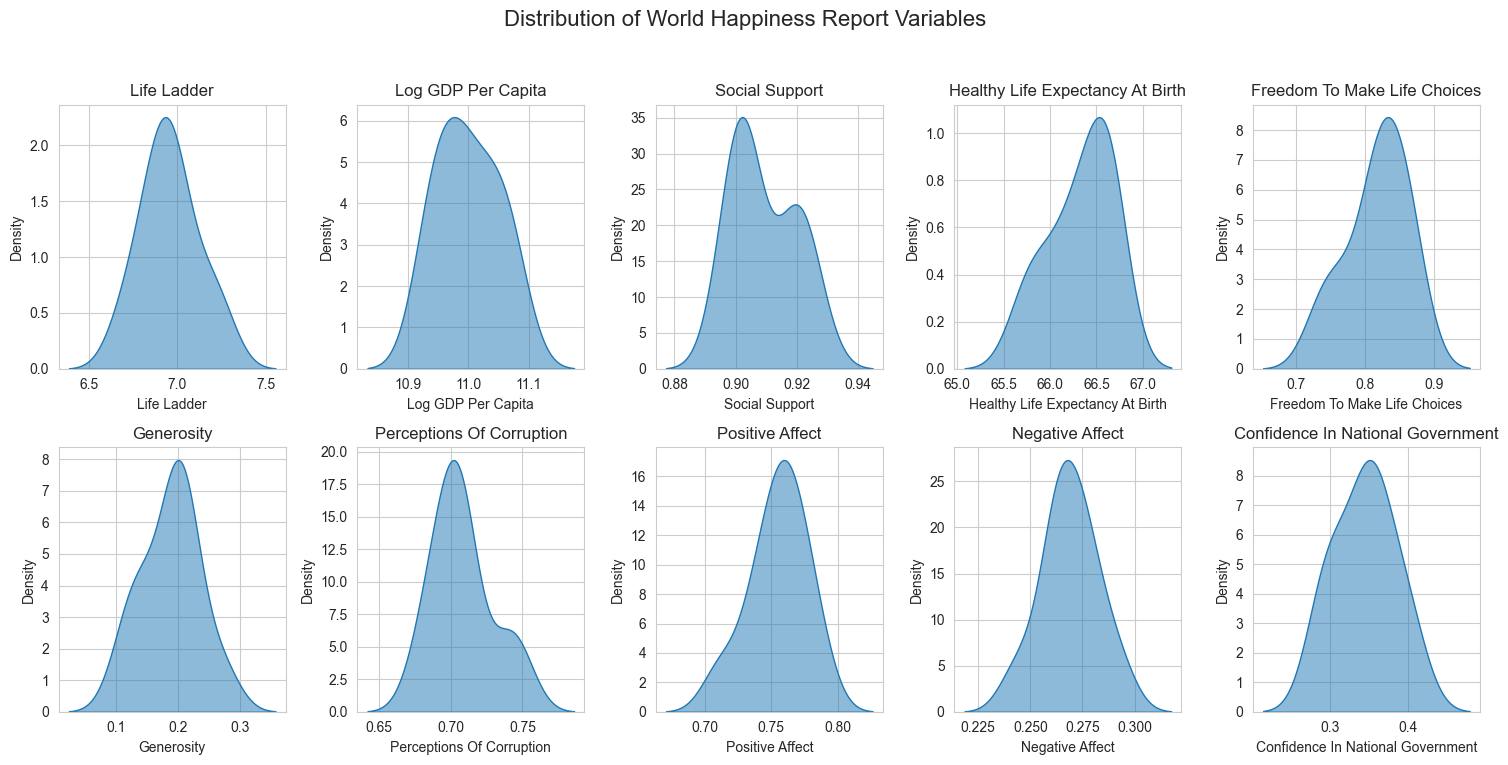

In [ ]:
#Plot Distrubution of Happiness Variables

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each subplot
for i in range(10):
    ax = axes[i]
    j = i + 3
    sns.kdeplot(data=US_happiness, x=hap_var[j], fill=True, palette="crest", alpha=.5, ax=ax)
    ax.set_title(f"{hap_var[j]}")  # Adding title to each subplot

fig.suptitle("Distribution of World Happiness Report Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

All of the variables in the World Happiness Report appears to be normally distributed across the years included in this dataset measured in the US.

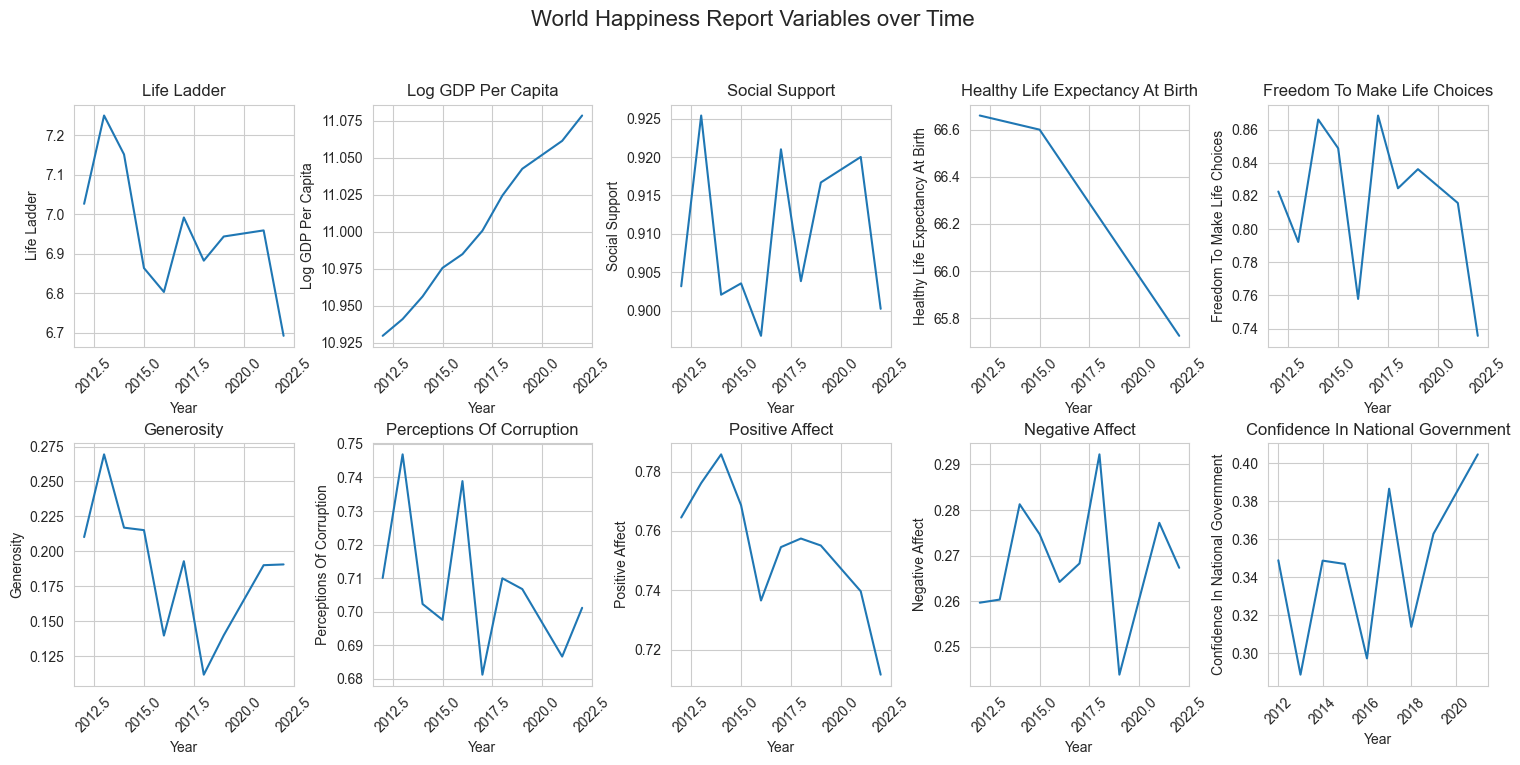

In [ ]:
#Plot Variables of Time

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each subplot
for i in range(10):
    ax = axes[i]
    j = i + 3
    sns.lineplot(data=US_happiness, x="Year", y=hap_var[j], ax=ax)
    ax.set_title(f"{hap_var[j]}")
    ax.set_xlabel("Year")
    ax.set_ylabel(hap_var[j])
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("World Happiness Report Variables over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

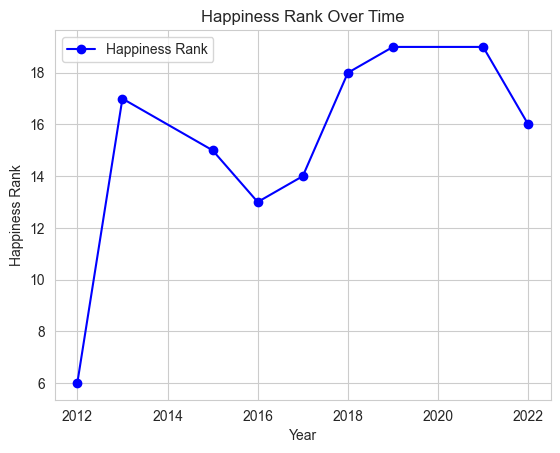

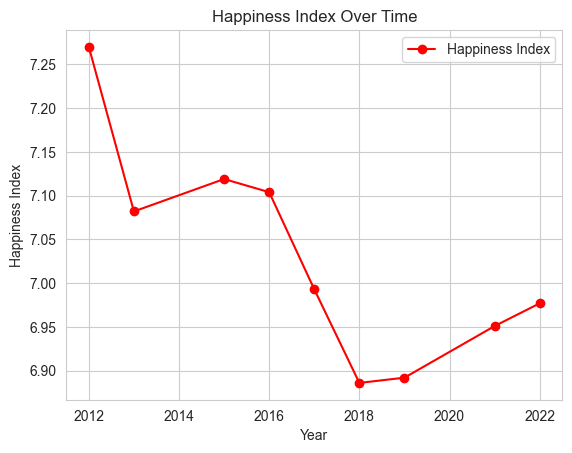

In [ ]:
#Happiness Rank 
happiness_rank.sort_values(by='Year', inplace=True)

#Plot
plt.plot(happiness_rank['Year'], happiness_rank['Happiness_Rank'], marker='o', linestyle='-', color='b', label='Happiness Rank')
plt.xlabel('Year')
plt.ylabel('Happiness Rank')
plt.title('Happiness Rank Over Time')
plt.legend()
plt.show()

plt.plot(happiness_rank['Year'], happiness_rank['Happiness_Index'], marker='o', linestyle='-', color='r', label='Happiness Index')
plt.xlabel('Year')
plt.ylabel('Happiness Index')
plt.title('Happiness Index Over Time')
plt.legend()
plt.show()

The Happiness rank has increased. It should be noted there is a big differnce in rank between 2012, the first year the report was created and 2013. Alternatively, the happiness score or index has been steadily decreasing over time. 

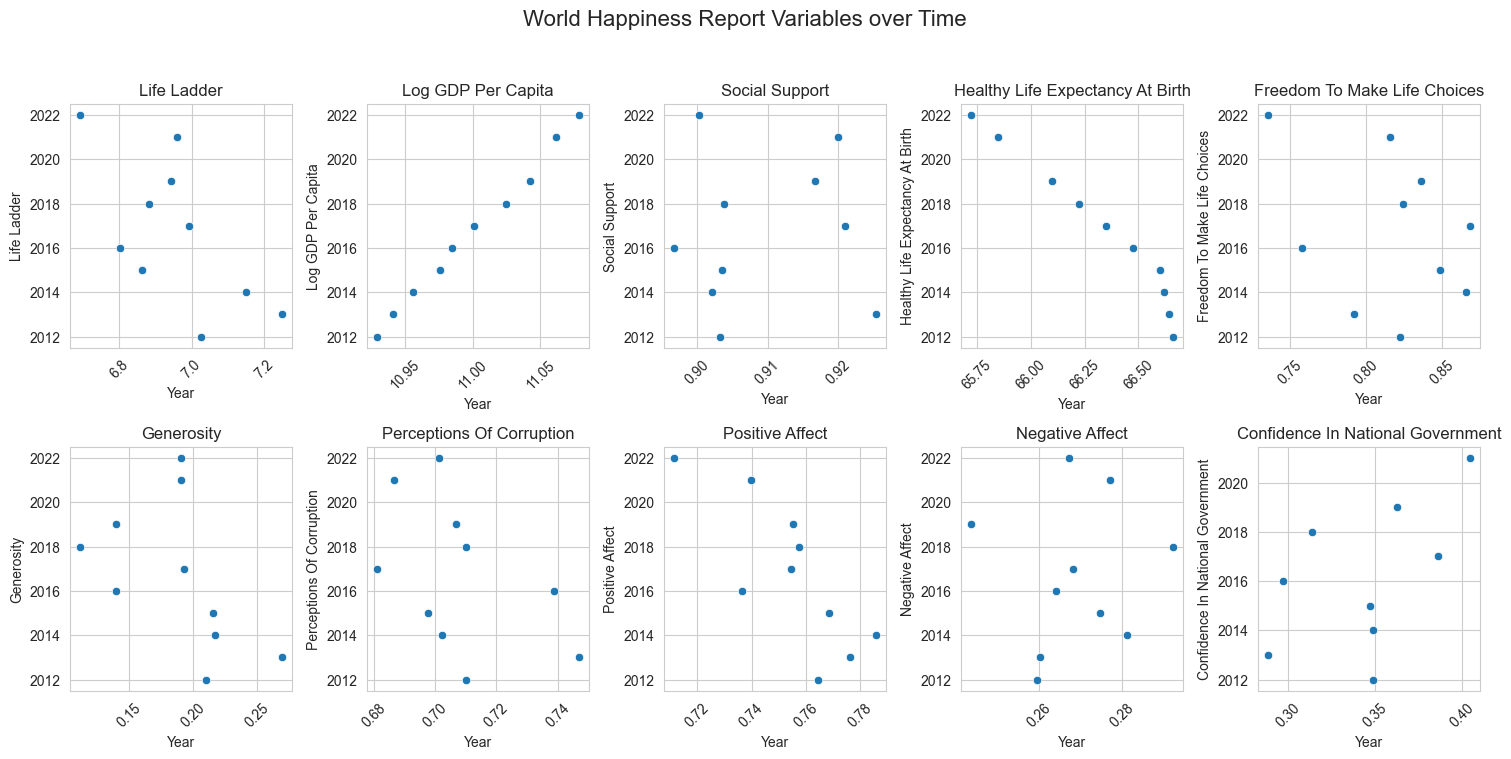

In [ ]:
#Scatterplots 
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each subplot
for i in range(10):
    ax = axes[i]
    j = i + 3
    sns.scatterplot(data=US_happiness, y="Year", x=hap_var[j], ax=ax)
    ax.set_title(f"{hap_var[j]}")
    ax.set_xlabel("Year")
    ax.set_ylabel(hap_var[j])
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("World Happiness Report Variables over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Description & Stability of Variables over time 

*   **Happiness Rank**: The Happiness rank has increased. It should be noted there is a big differnce in rank between 2012, the first year the report was created and 2013.

*   **Happiness Scorer**:(also referred to as Happiness Score) The happiness score or index has been steadily decreasing over time.

*   **Life Ladder**: (also referred to as Cantril life ladder). Life ladder is the national average reponse the Gallup World poll which is stated as  *“Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”* The national average response appears to be decreasing over time from 7 to 6. It is worth nothing the scale is smaller shown in the graph is quite small so the those fluctions are minor.  

*   **GDP per capita**: The GPD per captia is scaled logarithmically and normalized to a constant 2017 international dollar. The GPD per capita is increasing consistenly over time. Although the increase is quite small with a 0.14 difference on the log scale over 10 years that equates to 35 billion dollar increase.

*   **Social Support**: The Social support variables is the national average on a binary scale in response to the question *“If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”* This score appears to be quite consisten over time with slightly fluctions with a range of 2.5%.


*   **Health Life Expectancy at Birth**: The life expectancy at birth is monitored the World Health Organization. The US life expectrancy at birth appears to be decreasing over time with an almost 1% decrease over 10 year which is a considerable amount of lives on the scale of the US population of over 300 million people.

*   **Freedom**: Freedom to make life choices is the national average of responses to the question *“Are you satisfied or dissatisfied with your freedom to choose what you do with your life?”*  This variable appears to flucate over the past ten years.

*   **Generosity**: Generosity is represented by the residual national average to the question “Have you donated money to a charity in the past month?” on GDP per capita. Generosity flucates over time but appears to have a downward trend over the ten year period.

*   **Percent of Corruption**: Percent of Corruption is represented by indivudals perception of corruption which is measured by the national average of two true or false questions:
1.   “Is corruption widespread throughout the government or not”
2.   “Is corruption widespread within businesses or not?”
Percent of corruption fluctuates between years but appears to possibly be in a downward trend over the ten year period.

*   **Positive Affect**: Postive affect represents the national average of three Gallup World Pole Questions:
1.   “Did you smile or laugh a lot yesterday?”
2.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Enjoyment?”
3.   “Did you learn or do something interesting yesterday?”
Positive affect appears to be decreasing over the ten year period.

*   **Negative Affect**: Negative Affect is also the national average of three Gallip World Pole Questions:
1.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Worry?”
2.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Sadness?”
3.   Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Anger?”
Although postive affect appears to be decreasing, negative effect appears to consistent with small flucations.

*   **National Government**: The National Goverment Variables is relative to the 75th percentile of the global distribution of the first princial componenet of five measurements of confidence in the national government, judicial syste, courts, and honesty of election, local police force, and percieved corruption in business. This measurement fluctates but appears to be on an upward trend.

## Explore Individual Census Data

In [ ]:
##### Examine Null Counts 
null_counts = [df_id.where(col(column).isNull()).count() for column in df_id.columns]
null_counts_dict = dict(zip(df_id.columns, null_counts))
null_counts_dict = dict(sorted(null_counts_dict.items(), key=lambda item: item[1], reverse=True))
print("Number of null values in each column:")
print(null_counts_dict)

#Most Nulls are represented by 0 in categorical variables 

Number of null values in each column:
{'YEAR': 0, 'SAMPLE': 0, 'SERIAL': 0, 'CBSERIAL': 0, 'HHWT': 0, 'CLUSTER': 0, 'CPI99': 0, 'STRATA': 0, 'GQ': 0, 'PERNUM': 0, 'CBPERNUM': 0, 'PERWT': 0, 'FAMSIZE': 0, 'SEX': 0, 'AGE': 0, 'MARST': 0, 'RACE': 0, 'RACED': 0, 'CITIZEN': 0, 'HCOVANY': 0, 'SCHOOL': 0, 'EDUC': 0, 'EDUCD': 0, 'SCHLTYPE': 0, 'EMPSTAT': 0, 'EMPSTATD': 0, 'CLASSWKR': 0, 'CLASSWKRD': 0, 'UHRSWORK': 0, 'LOOKING': 0, 'POVERTY': 0, 'AINCTOT': 0, 'AFTOTINC': 0, 'AINCWELFR': 0, 'AINCINVST': 0}


There aren't any null values in the dataset. There still may be N/A or missing variables represented by numerical keys.They will be investigated individually for each variable. 

Text(0.5, 0.98, 'Distribution of Ind Income below 200k, Home Inc below 800k, and Poverty Score')

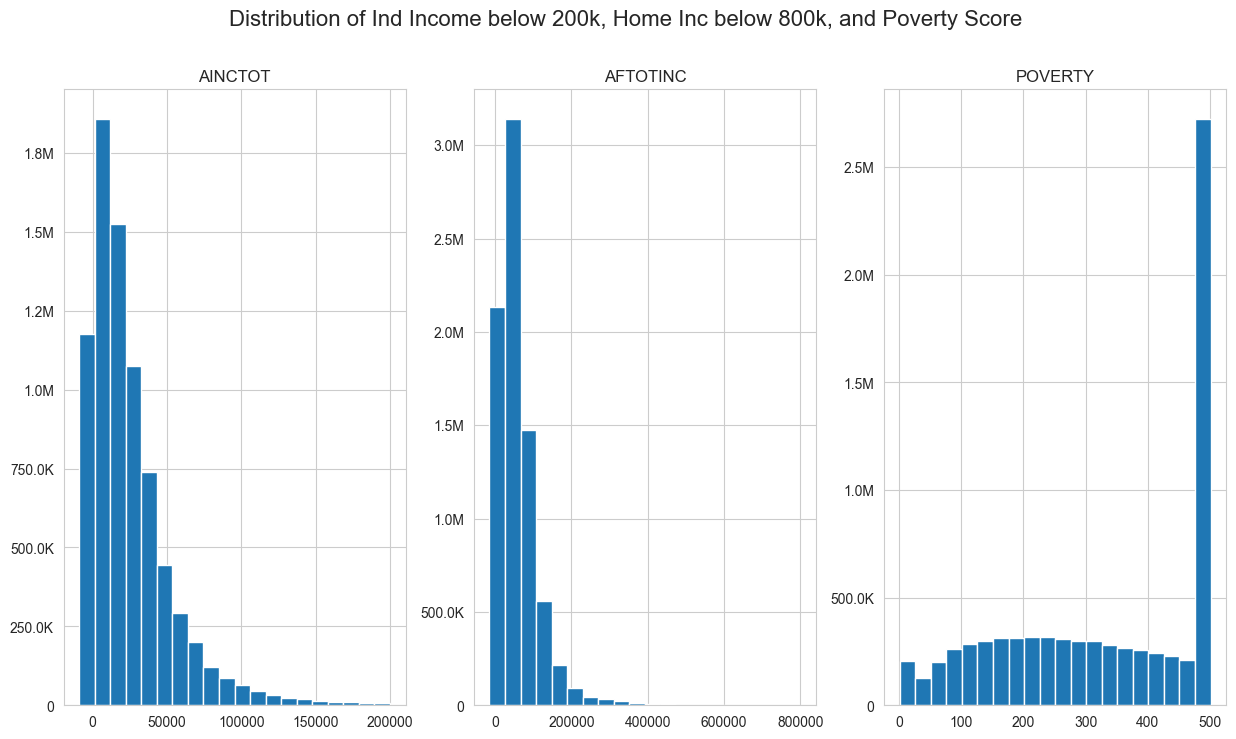

In [ ]:
df_id_inc = df_id.select("AINCTOT", "AFTOTINC", "POVERTY")
df_inc = df_id_inc.filter(df_id_inc.AINCTOT < 200000)
df_fam_inc = df_inc.filter(df_inc.AFTOTINC < 800000)
#df_pov = df_fam_inc.filter(df_fam_inc.POVERTY < 800000)

id_var = df_id_inc.columns

warnings.filterwarnings("ignore")


sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes = axes.flatten()

hist(axes[0], df_fam_inc.select(F.col(id_var[0])), bins=20)
hist(axes[1], df_fam_inc.select(F.col(id_var[1])), bins=20)
hist(axes[2], df_fam_inc.select(F.col(id_var[2])), bins=20)

axes[0].set_title(f"{id_var[0]}")
axes[1].set_title(f"{id_var[1]}")
axes[2].set_title(f"{id_var[2]}")
fig.suptitle("Distribution of Ind Income below 200k, Home Inc below 800k, and Poverty Score", fontsize=16)

In [ ]:
#Gender
temp = df_id.select("SEX")
temp.createOrReplaceTempView("temp")

## Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN SEX = 1 THEN 1 ELSE 0 END) as Male,
        SUM(CASE WHEN SEX = 2 THEN 1 ELSE 0 END) as Female,
        SUM(CASE WHEN SEX = 3 THEN 1 ELSE 0 END) as Missing
    FROM temp
""")

count_pd = pd.DataFrame(count.toPandas().stack())

# sns.countplot(x='0', data=count_pd)
# plt.title('Gender Distribution')
# plt.xticks(['Male', 'Female', 'Missing'])
# plt.show()
count_pd

0
0 Male     4892699
  Female   5107727
  Missing        0

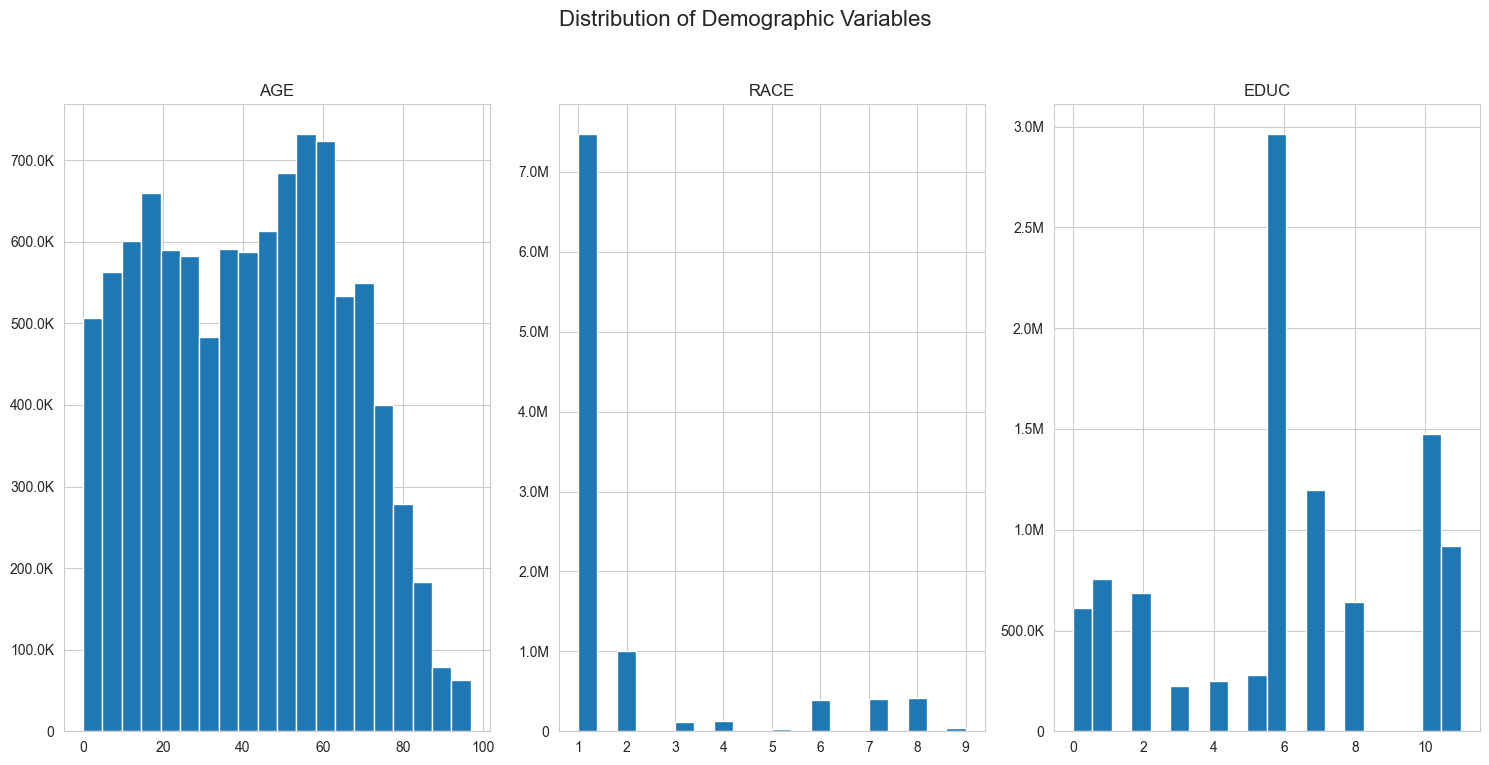

In [ ]:
#Plot Distrubution of Demographic Variables

df_dem = df_id.select("AGE", "RACE", "EDUC")

warnings.filterwarnings("ignore")

id_var = df_dem.columns

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes = axes.flatten()

#Loop through each subplot
for i in range(3):
    ax = axes[i]
    j = i 
    hist(ax, df_dem.select(F.col(id_var[j])), bins=20)
    ax.set_title(f"{id_var[j]}")  # Adding title to each subplot



fig.suptitle("Distribution of Demographic Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

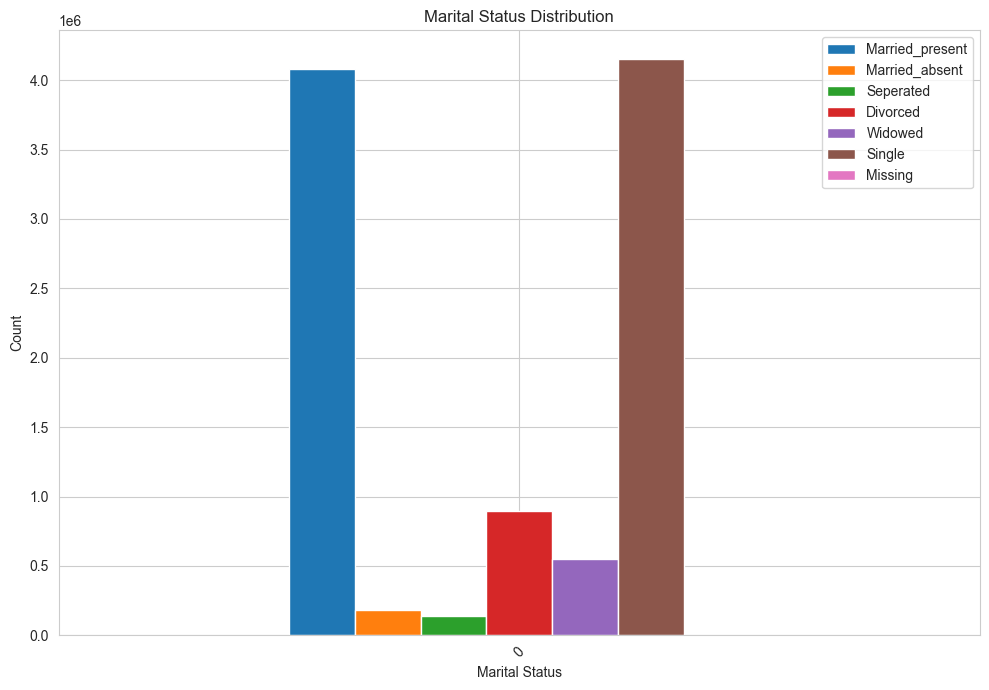

In [ ]:
temp = df_id.select("MARST")
temp.createOrReplaceTempView("temp")

## Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN MARST = 1 THEN 1 ELSE 0 END) as Married_present,
        SUM(CASE WHEN MARST = 2 THEN 1 ELSE 0 END) as Married_absent,
        SUM(CASE WHEN MARST = 3 THEN 1 ELSE 0 END) as Seperated,
        SUM(CASE WHEN MARST = 4 THEN 1 ELSE 0 END) as Divorced,
        SUM(CASE WHEN MARST = 5 THEN 1 ELSE 0 END) as Widowed,
        SUM(CASE WHEN MARST = 6 THEN 1 ELSE 0 END) as Single,
        SUM(CASE WHEN MARST = 9 THEN 1 ELSE 0 END) as Missing
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Marital Status Distribution')
plt.ylabel('Count')
plt.xlabel('Marital Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

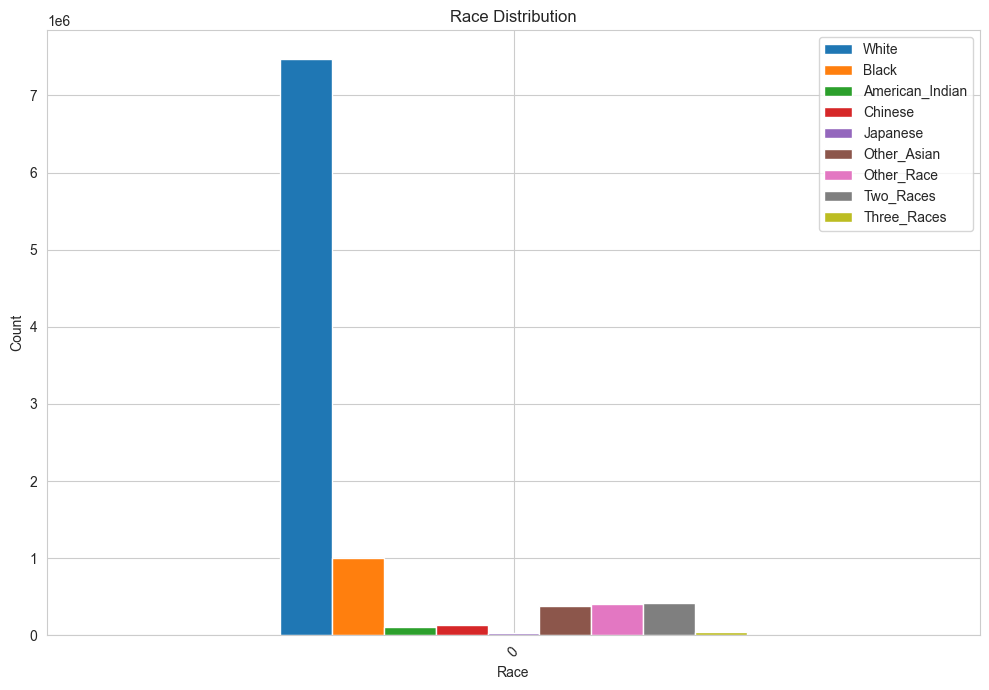

In [ ]:
temp = df_id.select("RACE")
temp.createOrReplaceTempView("temp")

# Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN RACE = 1 THEN 1 ELSE 0 END) as White,
        SUM(CASE WHEN RACE = 2 THEN 1 ELSE 0 END) as Black,
        SUM(CASE WHEN RACE = 3 THEN 1 ELSE 0 END) as American_Indian,
        SUM(CASE WHEN RACE = 4 THEN 1 ELSE 0 END) as Chinese,
        SUM(CASE WHEN RACE = 5 THEN 1 ELSE 0 END) as Japanese,
        SUM(CASE WHEN RACE = 6 THEN 1 ELSE 0 END) as Other_Asian,
        SUM(CASE WHEN RACE = 7 THEN 1 ELSE 0 END) as Other_Race,
        SUM(CASE WHEN RACE = 8 THEN 1 ELSE 0 END) as Two_Races,
        SUM(CASE WHEN RACE = 9 THEN 1 ELSE 0 END) as Three_Races
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Race Distribution')
plt.ylabel('Count')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

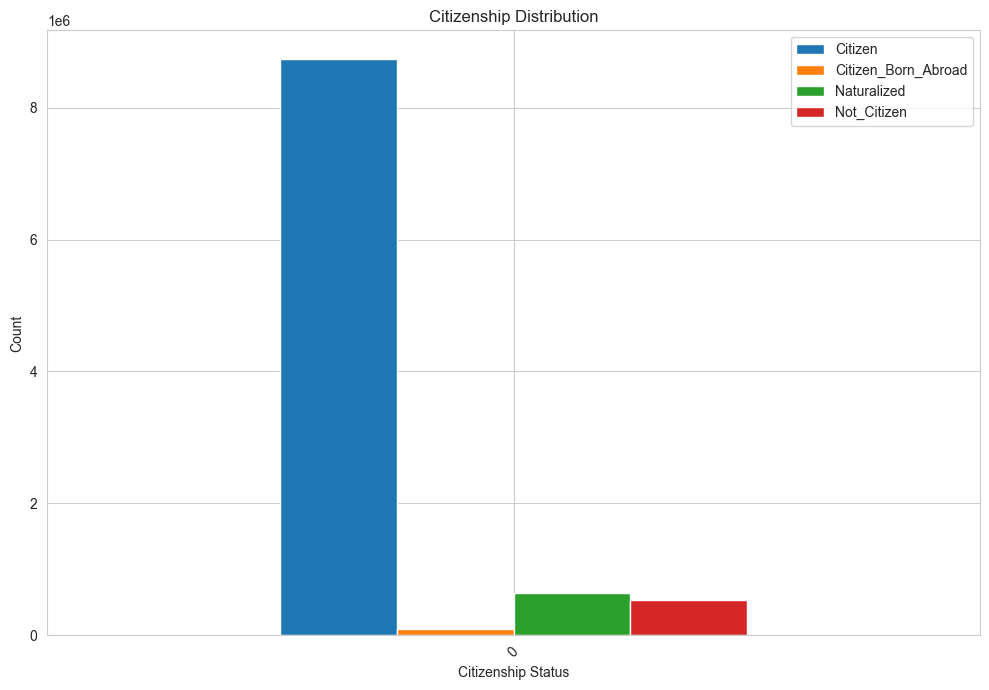

In [ ]:
temp = df_id.select("CITIZEN")
temp.createOrReplaceTempView("temp")

# Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN CITIZEN = 0 THEN 1 ELSE 0 END) as Citizen,
        SUM(CASE WHEN CITIZEN = 1 THEN 1 ELSE 0 END) as Citizen_Born_Abroad,
        SUM(CASE WHEN CITIZEN = 2 THEN 1 ELSE 0 END) as Naturalized,
        SUM(CASE WHEN CITIZEN = 3 THEN 1 ELSE 0 END) as Not_Citizen
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Citizenship Distribution')
plt.ylabel('Count')
plt.xlabel('Citizenship Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Examine Techinical Variables & size 
print("Souce Data:", list(df_id.select("SAMPLE").distinct().rdd.flatMap(lambda x: x).collect()))
print("Number of Instance per year:")
print(df_id.groupBy('YEAR').count().show())
print("Number of Variables:",len(df_id.columns))
print("Number of Individuals:", df_id.count())
print("Number of Households:", df_id.select("SERIAL").distinct().count())
print("Years Represented:", list(df_id.select("YEAR").distinct().rdd.flatMap(lambda x: x).collect()))
temp = df_id.select("SERIAL","YEAR", "CBSERIAL", "CLUSTER", "STRATA").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
count_by_year = spark.sql("""
    SELECT 
        YEAR,
        COUNT(DISTINCT SERIAL) AS Num_Households,
        COUNT(DISTINCT CBSERIAL) AS Num_CBSERIAL,
        COUNT(DISTINCT CLUSTER) AS Num_Clusters,
        COUNT(DISTINCT STRATA) AS Num_Strata
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")
count_by_year_pd = count_by_year.toPandas()
count_by_year_pd

Souce Data: [201201, 201301, 201401, 201501, 201601, 201701, 201801, 201901, 202101, 202201]
Number of Instance per year:
+----+-------+
|YEAR|  count|
+----+-------+
|2012| 997299|
|2013|1001492|
|2014|1000578|
|2015|1002140|
|2016| 997981|
|2017|1000345|
|2018|1000701|
|2019| 999725|
|2021| 999712|
|2022|1000453|
+----+-------+

None
Number of Variables: 35
Number of Individuals: 10000426
Number of Households: 1394624
Years Represented: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022]


,YEAR,Num_Households,Num_CBSERIAL,Num_Clusters,Num_Strata
0,2012,435982,435982,435982,2351
1,2013,295151,295151,295151,2351
2,2014,1113,1113,1113,44
3,2015,204530,204530,204530,2351
4,2016,140308,140308,140308,2351
5,2017,99448,99448,99448,2351
6,2018,73186,73186,73186,2351
7,2019,54960,54960,54960,2351
8,2021,43322,43322,43322,2351
9,2022,46624,46624,46624,2457


The individual census dataset contains 35 variables and 10,000,426 individuals in 1,394,624 seperate households over a 10 year period from 2012-2022. 2020 was excluded from analysis due to potential noise and sampling issues from the COVID-19 panedemic. Interestingly there is only ~1000 households in the 2014. This is not consistent with the household dataset and may be a sampling or household labeling error. It most likely isn't a household labeling error due since it appears in both the SERIAL, CBSERIAL, and CLUSTER variables. In general we do see the number of households decrease over time which is consisten with the household dataset indicating is most likely is not a sampling error. 

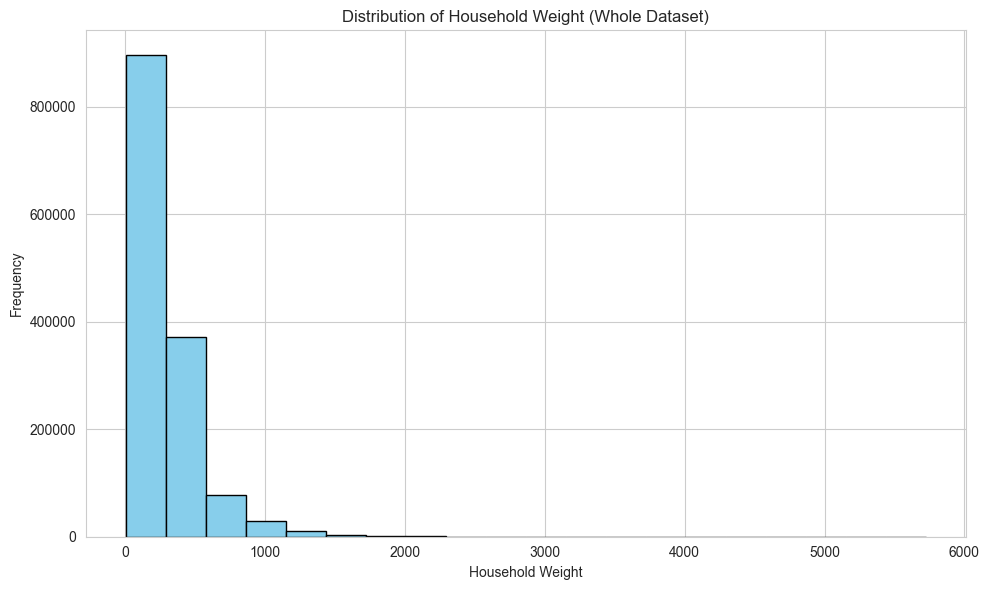

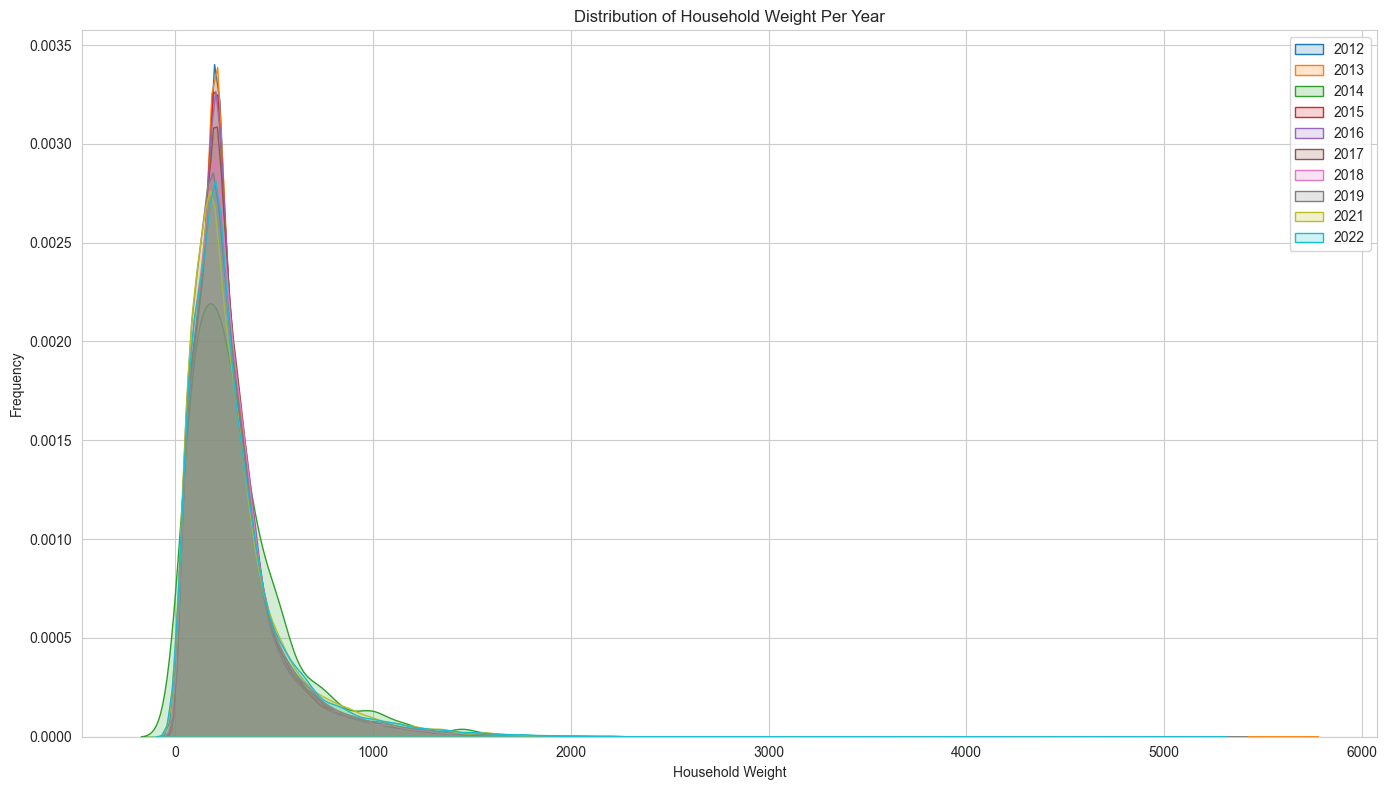

In [ ]:
## Look at household weight 
temp = df_id.select("SERIAL", "YEAR", "HHWT").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

# Plot distribution of HHWT over the whole dataset
plt.figure(figsize=(10, 6))
plt.hist(df_pd["HHWT"], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Household Weight (Whole Dataset)')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot distribution of HHWT per year
years = df_pd["YEAR"].unique()
bottom = None
plt.figure(figsize=(14, 8))
for year in years:
    df_year = df_pd[df_pd["YEAR"] == year]
    sns.kdeplot(df_year["HHWT"], label=str(year), fill=True, alpha=0.2)
plt.title('Distribution of Household Weight Per Year')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

+-------+------------------+------------------+
|summary|             PERWT|           FAMSIZE|
+-------+------------------+------------------+
|  count|          10000426|          10000426|
|   mean|323.83216462079037|3.0403208823304126|
| stddev| 271.1568923784088|1.7329246170886041|
|    min|              3.12|                 1|
|    max|          11291.44|                20|
+-------+------------------+------------------+

+-------+---------+
|FAMSIZE|Frequency|
+-------+---------+
|     12|     7416|
|      1|  1886939|
|     13|     2366|
|      6|   453672|
|     16|      448|
|      3|  1684596|
|      5|  1006475|
|     15|      900|
|      9|    40464|
|      4|  1806532|
|      8|    84168|
|      7|   188342|
|     10|    22540|
|     11|    11264|
|     14|     1484|
|      2|  2802130|
|     20|      100|
|     19|      171|
|     17|      221|
|     18|      198|
+-------+---------+

+-------------------+--------------------+------------------+
|         sum(PERWT)|  s

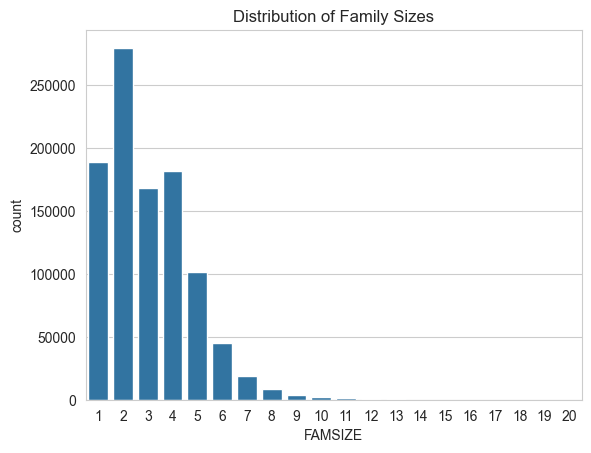

In [ ]:
#Individual  Household Variables

df_id.describe(['PERWT', 'FAMSIZE']).show()

# Frequency of each family size
family_size_distribution = df_id.groupBy('FAMSIZE').agg(F.count('*').alias('Frequency'))
family_size_distribution.show()

# Calculate weighted average family size
weighted_family_size = df_id.withColumn("weighted_size", df_id.FAMSIZE * df_id.PERWT).groupBy().sum('PERWT', 'weighted_size')
weighted_avg_family_size = weighted_family_size.withColumn("Weighted Average", F.col("sum(weighted_size)") / F.col("sum(PERWT)"))
weighted_avg_family_size.show()

sample_df = df_id.sample(fraction=0.1, withReplacement=False).toPandas()
sns.countplot(x='FAMSIZE', data=sample_df)
plt.title('Distribution of Family Sizes')
plt.show()

The dataset consists of over 10 million records, each representing a person's weight (PERWT) and family size (FAMSIZE) in the U.S. population. The average PERWT is about 324, suggesting each entry represents roughly 324 people, though the values range widely from 3.12 to 11,291.44. Family sizes average around 3.04 members with a typical range up to 20, though single-person households are most common. When adjusted for PERWT, the average family size is slightly higher at 3.17, indicating a more accurate representation of larger households in the population. This data underscores the diversity in household sizes, with a significant number of single-person households contrasted by rarer large families.

The distribution shows the frequency of various household sizes in a given population. The most common family size is 1, indicating a high number of single-person households, with the frequency sharply decreasing as the family size increases. Households with two to four members are also relatively common, suggesting that smaller family units dominate this demographic. In contrast, very large family sizes, such as those with more than 10 members, are significantly rarer, showing a minimal occurrence in the population. This distribution highlights the prevalence of smaller household units over larger ones within the studied group.

+-------+-------+
|HCOVANY|  count|
+-------+-------+
|      1| 904138|
|      2|9096288|
+-------+-------+

+-------+-------------------------+-------------------+
|HCOVANY|Total Weighted Population|         Proportion|
+-------+-------------------------+-------------------+
|      1|      3.382917940500005E8|0.10446071156322416|
|      2|      2.900167804660004E9| 0.8955392884367758|
+-------+-------------------------+-------------------+



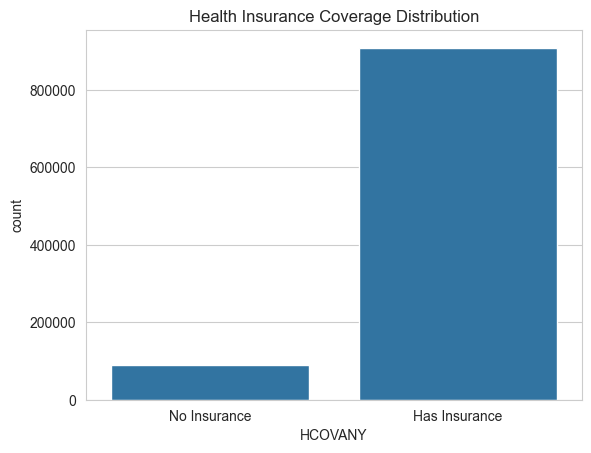

In [ ]:
#Individual Health Variables
df_id.groupBy('HCOVANY').count().show()


# Calculate total and weighted totals for insurance status
insurance_status = df_id.groupBy('HCOVANY').agg(F.sum('PERWT').alias('Total Weighted Population'))
total_population = insurance_status.groupBy().sum('Total Weighted Population').collect()[0][0]

# Calculate proportions
insurance_status = insurance_status.withColumn('Proportion', F.col('Total Weighted Population') / total_population)
insurance_status.show()


sample_df = df_id.sample(fraction=0.1, withReplacement=False).toPandas()


# Plot of health insurance coverage
sns.countplot(x='HCOVANY', data=sample_df)
plt.title('Health Insurance Coverage Distribution')
plt.xticks([0, 1], ['No Insurance', 'Has Insurance'])
plt.show()

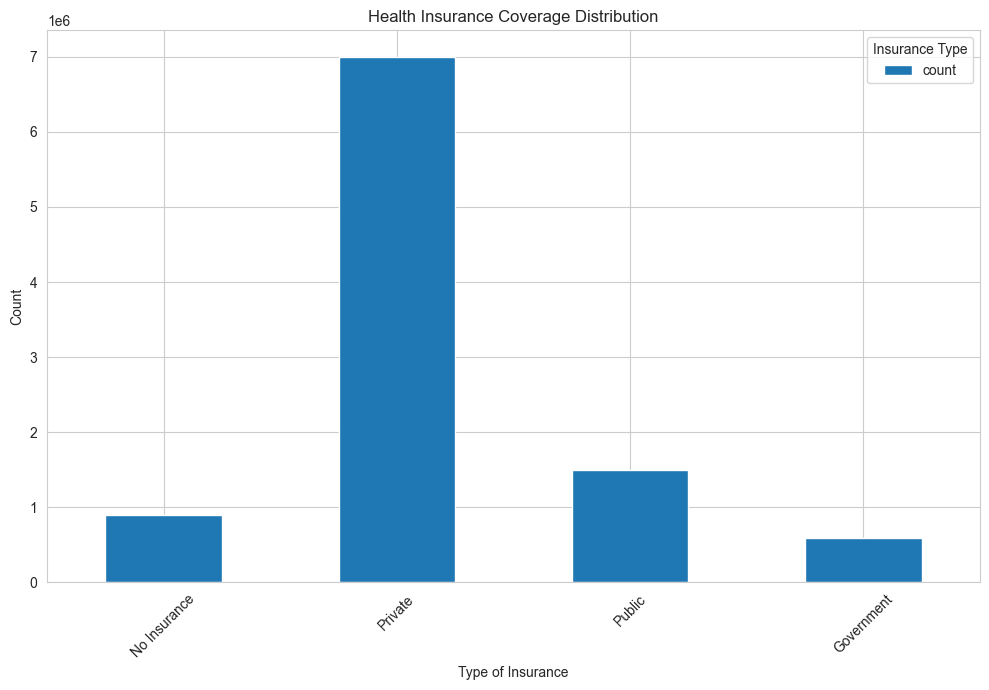

In [ ]:
data = {
    'Insurance Type': ['No Insurance', 'Private', 'Public', 'Government'],
    'count': [904138, 7000000, 1500000, 596288]
}

df = pd.DataFrame(data)

df.set_index('Insurance Type', inplace=True)

# Plotting
df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Health Insurance Coverage Distribution')
plt.ylabel('Count')
plt.xlabel('Type of Insurance')
plt.xticks(rotation=45)
plt.legend(title='Insurance Type')
plt.tight_layout()
plt.show()

The dataset analysis reveals that among the nearly 10 million responses, about 904,138 individuals reported having no health insurance, while 9,096,288 indicated they were insured. When adjusted for population representation using person weights (PERWT), it shows that approximately 338.3 million people are without health insurance, and about 2.9 billion have coverage. These weighted figures suggest that 10.45% of the population lacks health insurance, whereas 89.55% are insured. This significant disparity underscores a high rate of health insurance coverage within the surveyed population, highlighting that the vast majority have some form of health insurance.

The household weights are normally distributed with a right tail. This distribution is consistent across all 10 years sampled. The right tail most likely represent very common populations that are highly prevalent in the US popualtion. 

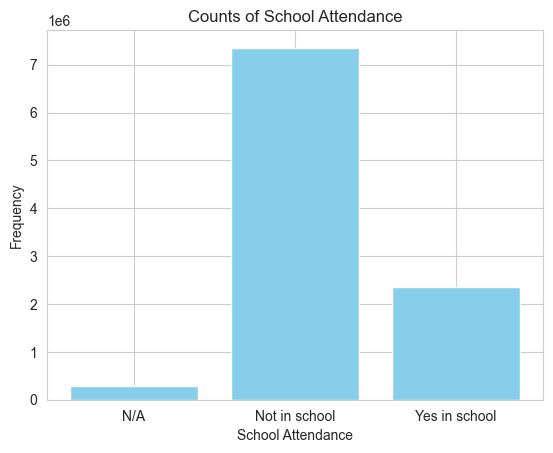

In [ ]:
#Exploring School Attendance

#(School attendance) School attendance during a specified period is reported by a numeric key. 
#     0. N/a
#     1. Not in school
#     2. Yes in school
#     8. Unknown 
#     9. Missing 

# Filter out rows with missing or unknown SCHOOL values
filtered_df_school = df_id.select("SCHOOL")


# Group by SCHOOL and count occurrences
school_counts = filtered_df_school.groupBy("SCHOOL").count().orderBy("SCHOOL")

# # Convert PySpark DataFrame to Pandas DataFrame
pandas_school_counts = school_counts.toPandas()

# Plot bar chart using Matplotlib
plt.bar(pandas_school_counts["SCHOOL"], pandas_school_counts["count"], color='skyblue')
plt.xlabel("School Attendance")
plt.ylabel("Frequency")
plt.title("Counts of School Attendance")
plt.xticks(pandas_school_counts["SCHOOL"], ["N/A", "Not in school", "Yes in school"]) # Replace numbers with corresponding labels
plt.show()

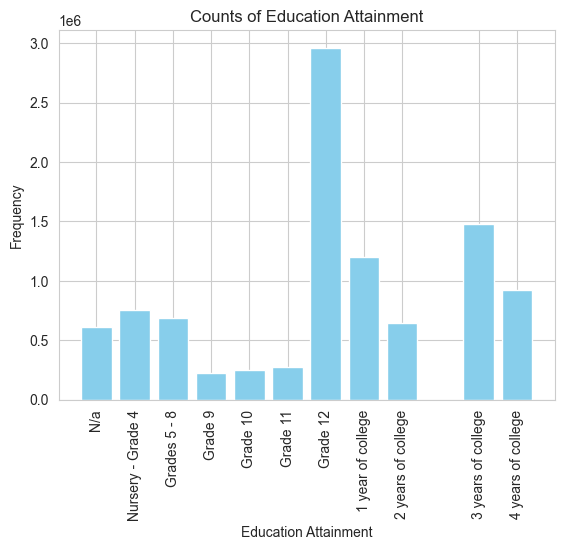

In [ ]:
# Exploring highest education completed
# EDUC: (Educational attainment [general version]) The highest achieved education completed is reported by a numeric key:
# 00. N/a or no schooling
# 01. Nursery - Grade 4
# 02. Grades 5 - 8 
# 03. Grade 9
# 04. Grade 10 
# 05. Grade 11
# 06. Grade 12
# 07. 1 year of college 
# 08. 2 years of college 
# 09. 3 years of college 
# 10. 4 years of college 

filtered_df_educ = df_id.select("EDUC")

# filtered_df_educ.show(10)

# Group by EDUC and count occurrences
educ_counts = filtered_df_educ.groupBy("EDUC").count().orderBy("EDUC")

# Convert PySpark DataFrame to Pandas DataFrame
pandas_educ_counts = educ_counts.toPandas()

# Plot bar chart using Matplotlib
plt.bar(pandas_educ_counts["EDUC"], pandas_educ_counts["count"], color='skyblue')
plt.xlabel("Education Attainment")
plt.ylabel("Frequency")
plt.title("Counts of Education Attainment")
plt.xticks(pandas_educ_counts["EDUC"], ["N/a", "Nursery - Grade 4", "Grades 5 - 8", "Grade 9", "Grade 10", "Grade 11", "Grade 12", "1 year of college", "2 years of college", "3 years of college", "4 years of college"]) # Replace numbers with corresponding labels
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.show()

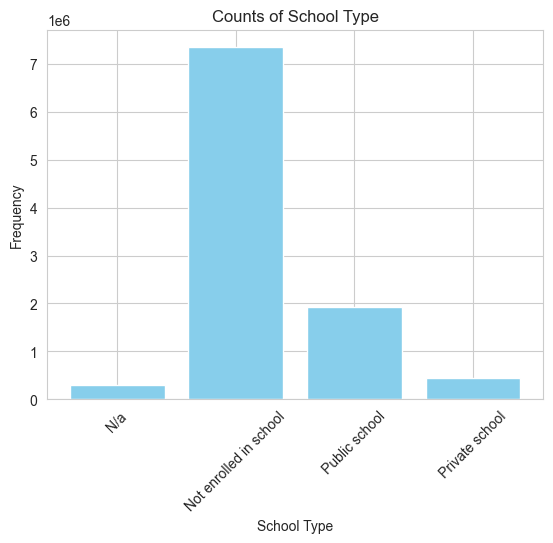

In [ ]:
# Exploring School Type (Public or Private School)
# SCHLTYPE**: (Public or private school) SCHLTYPE reports whether the school the individual is attending is public or private and reported as a numeric key: 
# 0. N/a 
# 1. Not enrolled in school 
# 2. Public school 
# 3. Private school

filtered_df_school_type = df_id.select("SCHLTYPE")

# filtered_df_educ.show(10)

# Group by school type and count occurrences
school_type_counts = filtered_df_school_type .groupBy("SCHLTYPE").count().orderBy("SCHLTYPE")

# Convert PySpark DataFrame to Pandas DataFrame
pandas_school_type_counts = school_type_counts.toPandas()


# Plot bar chart using Matplotlib
plt.bar(pandas_school_type_counts["SCHLTYPE"], pandas_school_type_counts["count"], color='skyblue')
plt.xlabel("School Type")
plt.ylabel("Frequency")
plt.title("Counts of School Type")
plt.xticks(pandas_school_type_counts["SCHLTYPE"], ["N/a", "Not enrolled in school", "Public school", "Private school"]) # Replace numbers with corresponding labels
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

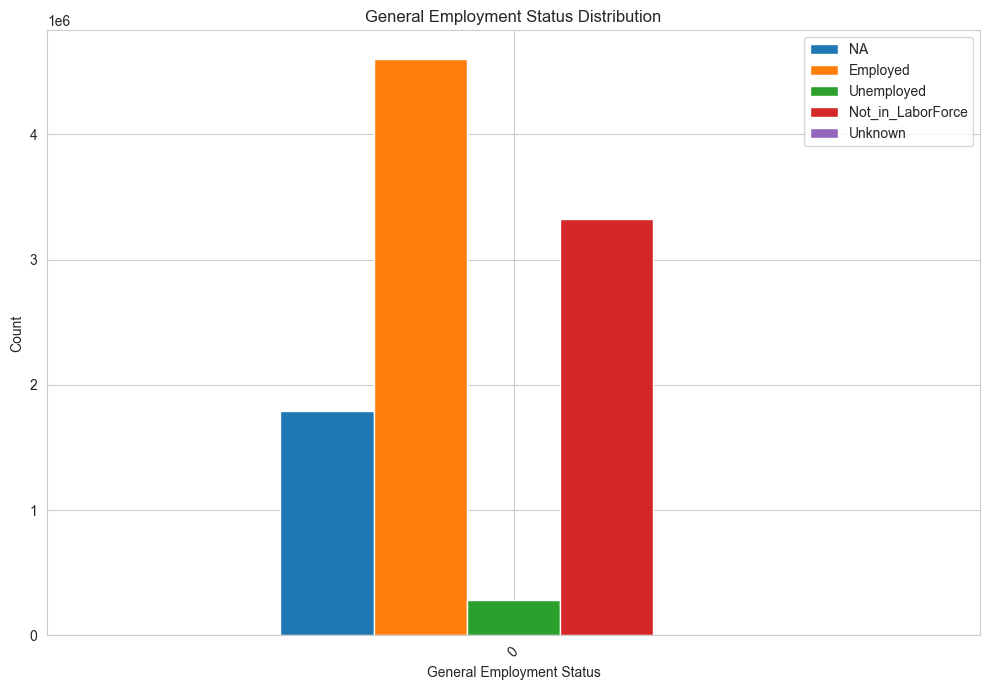

In [ ]:
#Employment Variables 
temp = df_id.select("EMPSTAT")
temp.createOrReplaceTempView("temp")

# Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN EMPSTAT = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN EMPSTAT = 1 THEN 1 ELSE 0 END) as Employed,
        SUM(CASE WHEN EMPSTAT = 2 THEN 1 ELSE 0 END) as Unemployed,
        SUM(CASE WHEN EMPSTAT = 3 THEN 1 ELSE 0 END) as Not_in_LaborForce,
        SUM(CASE WHEN EMPSTAT = 4 THEN 1 ELSE 0 END) as Unknown
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('General Employment Status Distribution')
plt.ylabel('Count')
plt.xlabel('General Employment Status')
plt.xticks(rotation=45)
plt.tight_layout()


+--------------------+-------+
|        EMPSTATD_str|  count|
+--------------------+-------+
|             At work|4470779|
|  Not in Labor Force|3323097|
|                 N/a|1794148|
|          Unemployed| 283088|
|Has job, not working|  93653|
|Armed forces, at ...|  35379|
|Armed forces, not...|    282|
+--------------------+-------+



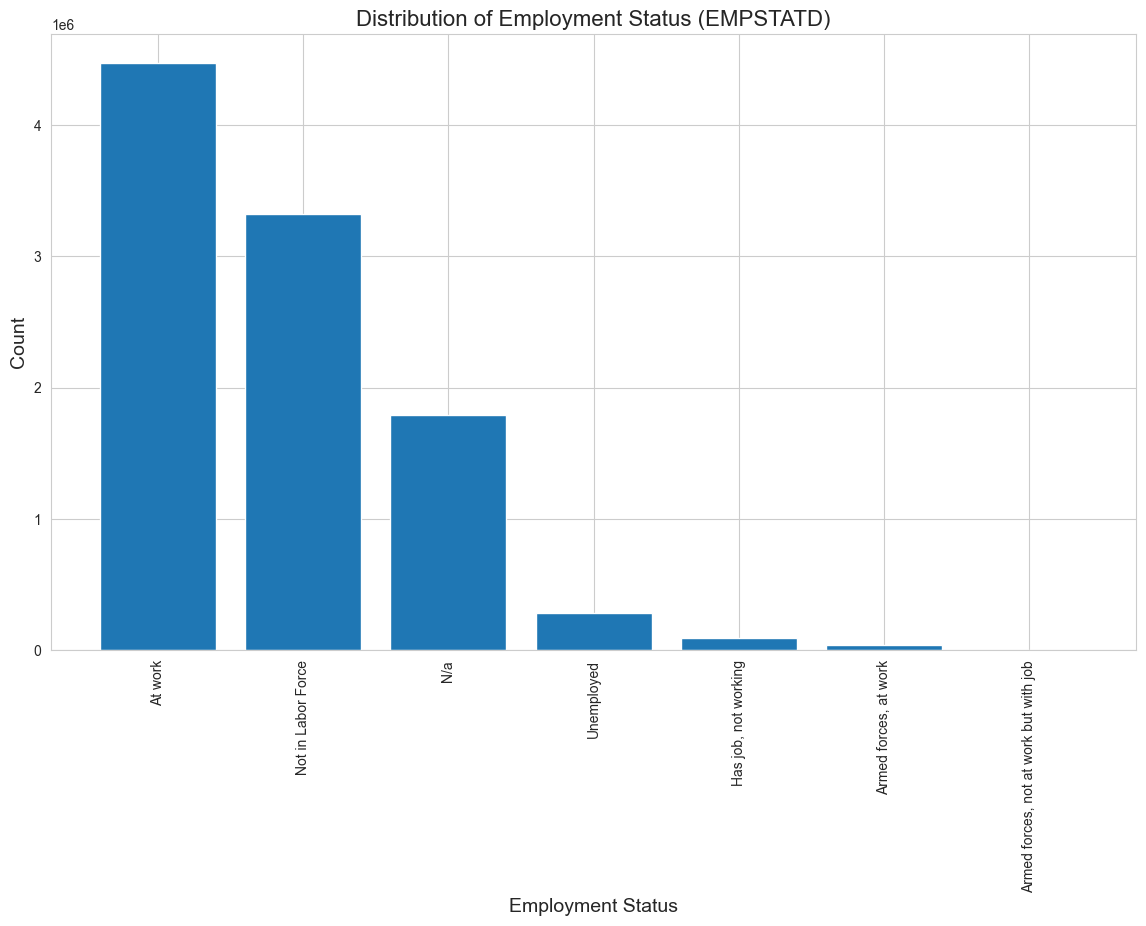

In [ ]:
#Exploring EMPSTATD: (Employment status [detailed version])  
# Create a new column for detailed employment status as string
df_id = df_id.withColumn(
    "EMPSTATD_str", 
    when(col("EMPSTATD") == 0, "N/a")
    .when(col("EMPSTATD") == 10, "At work")
    .when(col("EMPSTATD") == 11, "At work, public emergency")
    .when(col("EMPSTATD") == 12, "Has job, not working")
    .when(col("EMPSTATD") == 13, "Armed forces")
    .when(col("EMPSTATD") == 14, "Armed forces, at work")
    .when(col("EMPSTATD") == 15, "Armed forces, not at work but with job")
    .when(col("EMPSTATD") == 20, "Unemployed")
    .when(col("EMPSTATD") == 21, "Unemployed, experienced worker")
    .when(col("EMPSTATD") == 22, "Unemployed, new worker")
    .when(col("EMPSTATD") == 30, "Not in Labor Force")
    .when(col("EMPSTATD") == 31, "Not in Labor Force, housework")
    .when(col("EMPSTATD") == 32, "Not in Labor Force, unable to work")
    .when(col("EMPSTATD") == 33, "Not in Labor Force, school")
    .when(col("EMPSTATD") == 34, "Not in Labor Force, other")
    .when(col("EMPSTATD") == 99, "Unknown/illegible")
)

# Aggregate the data to get counts for each employment status
empstatd_counts = df_id.groupBy("EMPSTATD_str").count().orderBy("count", ascending=False)

# Show the aggregated data
empstatd_counts.show()

# Collect the data to the driver node
empstatd_counts_pd = empstatd_counts.collect()

# Extract the data for plotting
categories = [row['EMPSTATD_str'] for row in empstatd_counts_pd]
counts = [row['count'] for row in empstatd_counts_pd]

# Set the plot size
plt.figure(figsize=(14, 8))

# Create the bar plot
plt.bar(categories, counts)

# Set the plot title and labels
plt.title('Distribution of Employment Status (EMPSTATD)', fontsize=16)
plt.xlabel('Employment Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

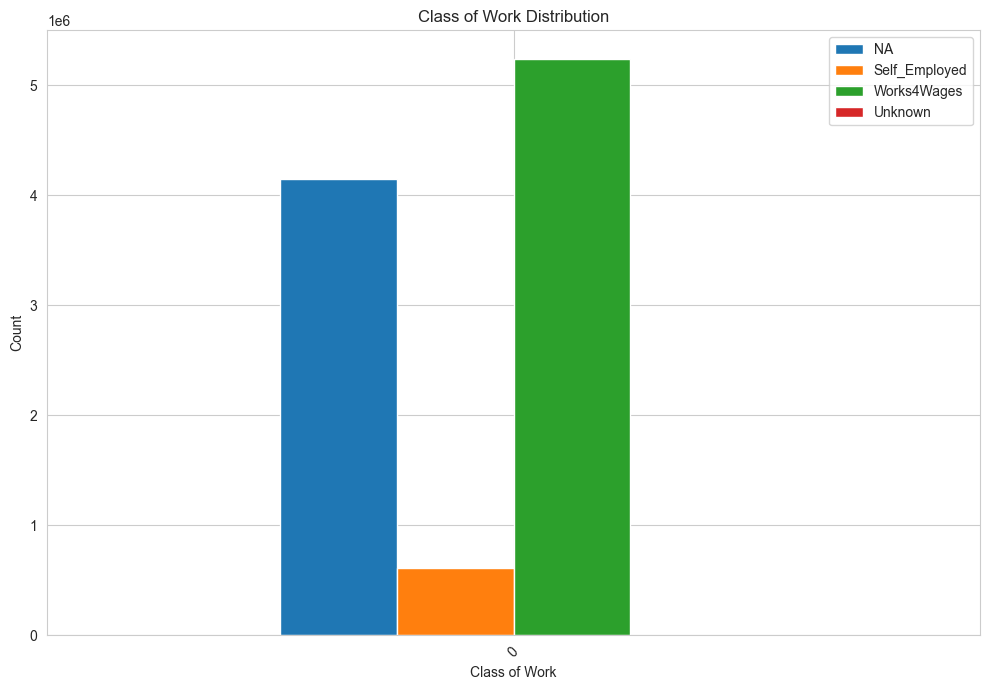

In [ ]:
#Employment Variables 
temp = df_id.select("CLASSWKR")
temp.createOrReplaceTempView("temp")

# Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN CLASSWKR = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN CLASSWKR = 1 THEN 1 ELSE 0 END) as Self_Employed,
        SUM(CASE WHEN CLASSWKR = 2 THEN 1 ELSE 0 END) as Works4Wages,
        SUM(CASE WHEN CLASSWKR = 9 THEN 1 ELSE 0 END) as Unknown
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Class of Work Distribution')
plt.ylabel('Count')
plt.xlabel('Class of Work')
plt.xticks(rotation=45)
plt.tight_layout()


+----+--------------------+------+
|YEAR|        EMPSTATD_str| count|
+----+--------------------+------+
|2012|Armed forces, at ...|  3537|
|2012|Armed forces, not...|    22|
|2012|             At work|429447|
|2012|Has job, not working|  9255|
|2012|                 N/a|188645|
|2012|  Not in Labor Force|323441|
|2012|          Unemployed| 42952|
|2013|Armed forces, at ...|  3329|
|2013|Armed forces, not...|    34|
|2013|             At work|438169|
|2013|Has job, not working|  9550|
|2013|                 N/a|188953|
|2013|  Not in Labor Force|322985|
|2013|          Unemployed| 38472|
|2014|Armed forces, at ...|  3409|
|2014|Armed forces, not...|    24|
|2014|             At work|441195|
|2014|Has job, not working|  9446|
|2014|                 N/a|185460|
|2014|  Not in Labor Force|328230|
+----+--------------------+------+
only showing top 20 rows



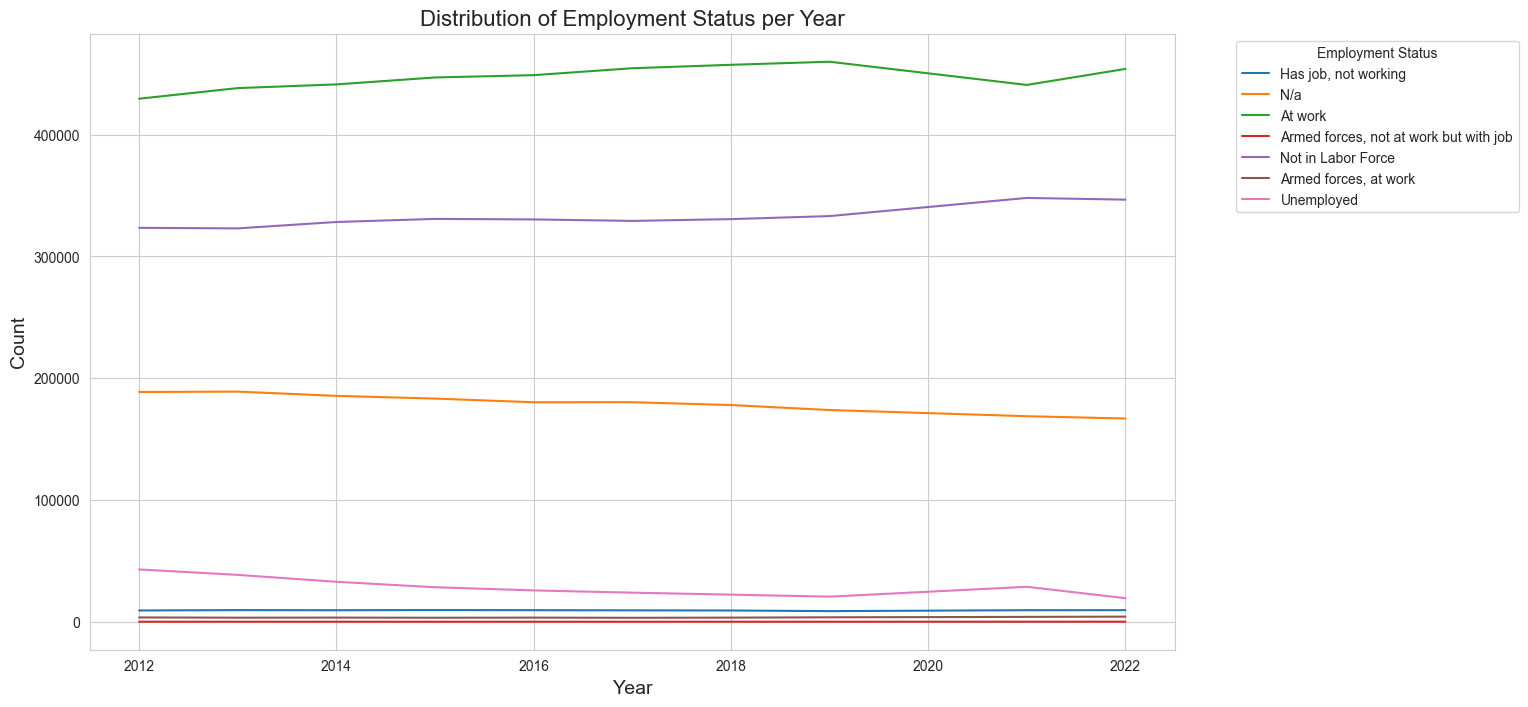

In [ ]:
#EMPSTATD: (Employment status [detailed version])  over the years
# Aggregate the data to get counts for each employment status per year
employment_per_year = df_id.groupBy("YEAR", "EMPSTATD_str").count().orderBy("YEAR", "EMPSTATD_str")

# Show the aggregated data
employment_per_year.show()

# Collect the data to the driver node
employment_per_year_pd = employment_per_year.collect()

# Convert collected data to a dictionary for easier plotting
data_dict = {}
for row in employment_per_year_pd:
    year = row['YEAR']
    emp_status = row['EMPSTATD_str']
    count = row['count']
    
    if year not in data_dict:
        data_dict[year] = {}
    data_dict[year][emp_status] = count

# Extract unique employment statuses and years
emp_statuses = df_id.select("EMPSTATD_str").distinct().rdd.flatMap(lambda x: x).collect()
years = sorted(df_id.select("YEAR").distinct().rdd.flatMap(lambda x: x).collect())

# Prepare data for plotting
plot_data = {status: [data_dict.get(year, {}).get(status, 0) for year in years] for status in emp_statuses}

# Set the plot size
plt.figure(figsize=(14, 8))

# Plot each employment status as a line
for status, counts in plot_data.items():
    plt.plot(years, counts, label=status)

# Set the plot title and labels
plt.title('Distribution of Employment Status per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add a legend
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Hours Worked per Week')

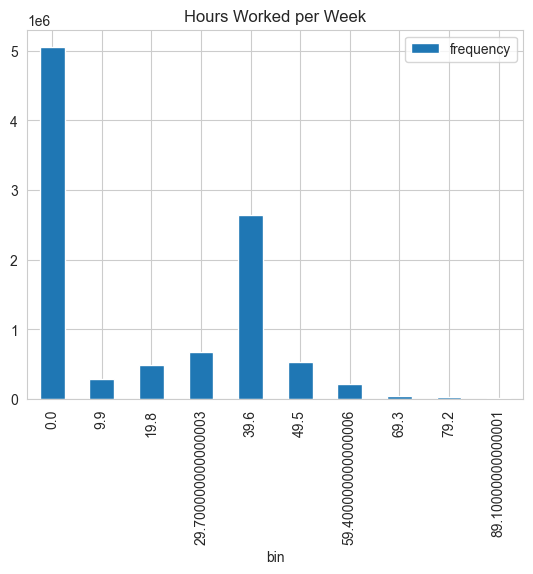

In [ ]:
#Hours of Work
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
#df_id.histogram("UHRSWORK")
histo = df_id.select("UHRSWORK").rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(list(zip(*histo)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')
plt.title('Hours Worked per Week') 
# df_pd = temp.toPandas()

# # Plot distribution 
# plt.figure(figsize=(10, 6))
# plt.hist(df_pd["UHRSWORK"], bins=20, color='skyblue', edgecolor='black')
# plt.title('Distribution of Hours of Work)')
# plt.xlabel('Hours of Work')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

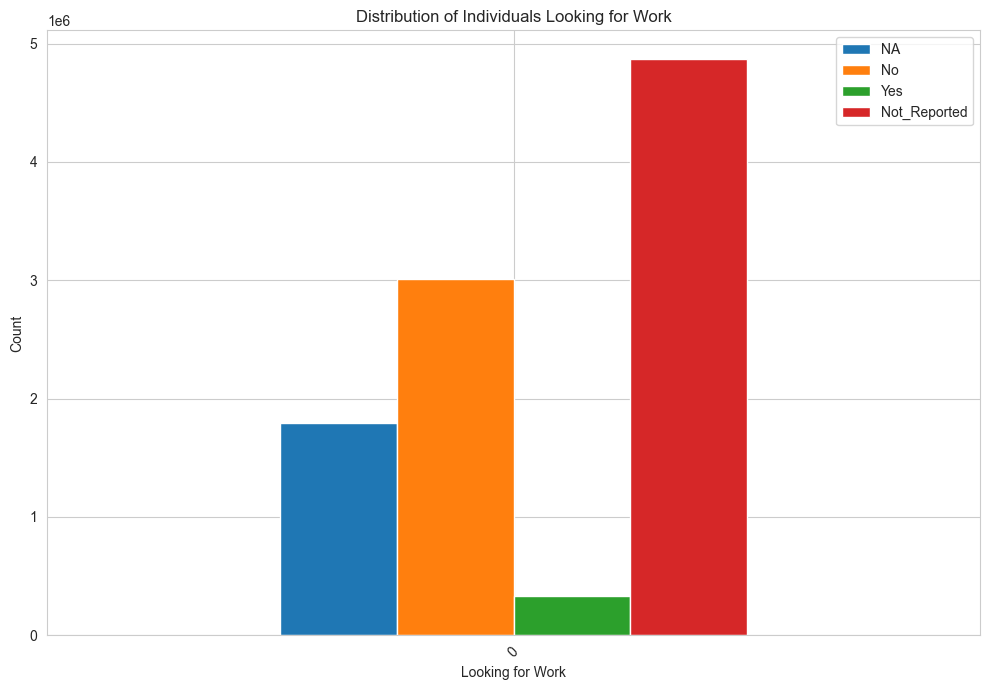

In [ ]:
#Employment Variables 
temp = df_id.select("LOOKING")
temp.createOrReplaceTempView("temp")

# Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN LOOKING = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN LOOKING = 1 THEN 1 ELSE 0 END) as No,
        SUM(CASE WHEN LOOKING = 2 THEN 1 ELSE 0 END) as Yes,
        SUM(CASE WHEN LOOKING = 3 THEN 1 ELSE 0 END) as Not_Reported
    FROM temp
""")

count_pd = count.toPandas()

count_pd.plot(kind='bar', stacked=False, figsize=(10, 7))
plt.title('Distribution of Individuals Looking for Work')
plt.ylabel('Count')
plt.xlabel('Looking for Work')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot above illustrates the distribution of various employment statuses in the United States from 2012 to 2022. The data is derived from the American Community Survey (ACS) and categorizes employment statuses into detailed groups such as "At work," "Has job, not working," "Unemployed," "Not in Labor Force," among others. Notably, the categories "At work," "Not in Labor Force," and "Unemployed" show significant trends over the years. The "At work" category generally increases, indicating a rise in employment. Conversely, the "Unemployed" category shows a declining trend, reflecting improvements in employment rates. The "Not in Labor Force" category remains relatively stable, with slight variations over the years. 

#### Individual Census Data Variables 
The individual census dataset contains 35 variables and 10,000,426 individuals in 1,394,624 seperate households over a 10 year period from 2012-2022. 2020 was excluded from analysis due to potential noise and sampling issues from the COVID-19 panedemic. Interestingly there is only ~1000 households in the 2014. This is not consistent with the household dataset and may be a sampling or household labeling error. It most likely isn't a household labeling error due since it appears in both the SERIAL, CBSERIAL, and CLUSTER variables. In general we do see the number of households decrease over time which is consisten with the household dataset indicating is most likely is not a sampling error. 

##### Technical Variables 
*   **Year**: Census year ranging from 2012-2022. 2020 was exluded due to potential bias being introduced from the COVID-19 pandemic. 
*   **SAMPLE** (IPUMS sample identifier) The SAMPLE variable identifies the dataset from which the sample was pulled. This data was extracted from the 10 single year sample datasets. 
*   **SERIAL** (Household serial number) The SERIAL variable is a unique identifier of each household. This dataset contains 1,394,624 households. 
*   **CBSERIAL**: (Original Census Bureau household serial number) The CBSERIAL variable is a another unique identifier of each household. This dataset contains 1,394,624 households.
*   **HHWT**: (Household weight) The household weights are consistently distributed each year. The weights are normally distributed with a right tail most likely representing very common populations within the US. 
*   **PERNUM**: (Person number in sample unit) PERNUM is a key that report all people in a household in consecutive order. Since this dataset is a random sample, not everyone in a household may be included so this value cannot be used.
*   **CBPERNUM**: (Original Census Bureau Person number in sample unit) PERNUM reports all people in a household in consecutive order. Since this dataset is a random sample, not everyone in a household may be included so this value cannot be used.
*   **CLUSTER**: (Household cluster for variance estimation) Clusters using Taylor series linear approximation for use with Strava. Will be ignored. Each household has a unique cluster number and since we are not using Strava, we will not be using this variable. 
*   **CPI99**: (CPI-U adjustment factor to 1999 dollars) This is a mutliplier available to convert dollar figures to the dollar amount in 2000 census ensuring dollar figures are comparables between years. It was utilized to covert all monetary values. 
*   **STRATA**: (Household strata for variance estimation) Correction of complex samples for Cluster variable. Since we are not using Strava, we will not be using this variable.

##### Household Variables 
*   **PERWT**: (Person weight) Person weight report the number of people in the US population within a given sample this individual represents.
*   **FAMSIZE**: (Number of own family members in household) FAMSIZE report the number of family members including the himself or herself residing in the household. Family is defined as people related by blood, marriage, cohabition, or adoption. 
*   **GQ**: (Group quarters status)

##### Demographic Variables 
*   **SEX**: (Sex) Gender is represented by numberic values. 
     1. Male 
     2. Female
     3. Missing
*   **AGE**: (Age) Age is reported in years as of last birthday. 
*   **MARST**: (Marital status) Maritial status is a catagorical variables reported by a numeric key. 
     1. Married, spouse present
     2. Married, spouse absent
     3. Seperated
     4. Divorced
     5. Widowed
     6. Never married/single 
     9. Blank/missing 
*   **RACE**: (Race [general version]) Race is a catagorical variable reported by a numeric key. 
    1. White
    2. Black/African American
    3. American Indian or Alaskan Native
    4. Chinese
    5. Japanese
    6. Pacific Islander or other asian 
    7. Other race
    8. Two major races
    9. Three or more major races
*   **RACED**: (Race [detailed version]) RaceD is a catagorical variables with more descriptive labels repored by a numeric key. 
*   **CITIZEN**: (Citizenship status)

##### Education Variables 
*   **SCHOOL**: (School attendance) School attendance during a specified period is reported by a numeric key. 
    0. N/a
    1. Not in school
    2. Yes in school
    8. Unknown 
    9. Missing 
*   **EDUC**: (Educational attainment [general version]) The highest achieved education completed is reported by a numeric key: 
    00. N/a or no schooling
    01. Nursery - Grade 4
    02. Grades 5 - 8 
    03. Grade 9
    04. Grade 10 
    05. Grade 11
    06. Grade 12
    07. 1 year of college 
    08. 2 years of college 
    09. 3 years of college 
    10. 4 years of college 
    11. 5+ years of college 
    99. Missing 
*   **EDUCD**: (Educational attainment [detailed version]) A more detailed description of the highest achieved education level is reported by a numeric key. The key is described in the xml file due to length. 
*   **SCHLTYPE**: (Public or private school) SCHLTYPE reports whether the school the individual is attending is public or private and reported as a numeric key: 
    0. N/a 
    1. Not enrolled in school 
    2. Public school 
    3. Private school
    4. Church-related
    5. Parochial 
    6. Other private (1980)
    7. Other private (1970)

##### Health Variables
*   **HCOVANY**: (Any health insurance coverage) Health insurance coverage at time of filling out census regardless of private, public or goverment subsidized is reported with a numeric jey. 
    1. No health insurance
    2. Has health insurance

##### Employment & Income Variables
*   **EMPSTAT**: (Employment status [general version]) Employment status is a catagorical variable represented by a numeric key. 
    0. N/a
    1. Employed
    2. Unemployed
    3. Not in labor force
    4. Unknown/ illegible 
*   **EMPSTATD**: (Employment status [detailed version]) EMPSTATD reports more detailed catagories of employment status. 
    00. N/a
    10. At work
    11. At work, public emergency 
    12. Has job, not working 
    13. Armed forces
    14. Armed forces, at work
    15. Armed forces, not at work but with job 
    20. Unemployed
    21. Unemployed, experience worker
    22. Unemployed, new worker 
    30. Not in Labor Force 
    31. Not in Labor Force, housework 
    32. Not in Labor Force, unable to work 
    33. Not in Labor Force, school 
    34. Not in Labor Force, other 
    99. Unknown/illegible 
*   **CLASSWKR**: (Class of worker [general version]) Class of work describes whether a individual is self-employed or employed by a corporation reported as a numeric key. 
    0. N/a 
    1. Self-employed 
    2. Works for wages 
    9. Unknown 
*   **CLASSWKRD**: (Class of worker [detailed version]) CLASSWKRD reports class of work in more descriptive catagories reported as a numeric key. 
    00. N/a
    10. Self-employed 
    11. Employer
    12. Working on own account 
    13. Self-employed, not incorporated
    14. Self-employed, incorporated
    20. Works for wages
    21. Works for salary 
    22. Wage/salary, private
    23. Wage/salary at non-profit 
    25. Wage/salary, goverment 
    26. Armed forces
    27. State government employee
    28. Local government employee
    29. Unpaid family worker
    98. Illegible 
    99. Unknown 
*   **UHRSWORK**: (Usual hours worked per week) The usual number of hours work per week is reported as discrete numeric value. 
*   **LOOKING**: (Looking for work) Looking for work is describes as the individual actively pursueing new employment in the last week reported as a numeric key. 
    0. N/a
    1. No
    2. Yes
    3. Not reported 
*   **INCTOT**: (Total personal income) Total personal income pre-tax is not adjusted for inflation and needs to be adjusted. 

      **How is this displayed?? NEEDS CORRECTION**

*   **FTOTINC**: (Total family income) Total family incomes pre-tax reports the income of one's family as defined by the FAMUNIT variable and is not adjusted for inflation. 

      **How is this displayed?? NEEDS CORRECTION**

*   **INCWELFR**: (Welfare (public assistance) income) Pre-tax public assistance income by the family for the year is not inflation adjusted and does not include private charities. 

      **How is this displayed?? NEEDS CORRECTION**

*   **INCINVST**: (Interest, dividend, and rental income) The total income recieved or lost by the indivdual from investments, rent, trusts, royalties and/or dividends is not adjusted for inflation. 

      **How is this displayed?? NEEDS CORRECTION**

*   **POVERTY**: (Poverty status) Poverty is classified by family and is descriped as percentage abover or below the poverty line. 

      **How is this displayed?? NEEDS CORRECTION**


## Explore Household Census Data

In [ ]:
#Show head of dataframe
df_hh.show(5)

+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+--------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|YEAR|SAMPLE|SERIAL|     CBSERIAL|   HHWT|HHTYPE|      CLUSTER|CPI99|STATEICP|MET2023|STRATA| GQ|FARM|OWNERSHP|OWNERSHPD|TAXINCL|INSINCL|FOODSTMP|CINETHH|VEHICLES|COUPLETYPE|NFAMS|ARENTGRS|ACONDOFEE|         AMOBLHOME|         AHHINCOME|           AVALUEH|         ACOSTELEC|          ACOSTGAS|         ACOSTWATR|         ACOSTFUEL|
+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+--------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|

In [ ]:
##### Examine Null Counts 
null_counts = [df_hh.where(col(column).isNull()).count() for column in df_hh.columns]
null_counts_dict = dict(zip(df_hh.columns, null_counts))
null_counts_dict = dict(sorted(null_counts_dict.items(), key=lambda item: item[1], reverse=True))
print("Number of null values in each column:")
print(null_counts_dict)

#Most Nulls are represented by 0 or another number in categorical variables. These will be investigated with the individual markers. 

Number of null values in each column:
{'MET2023': 3941494, 'COUPLETYPE': 3057399, 'CINETHH': 435981, 'YEAR': 0, 'SAMPLE': 0, 'SERIAL': 0, 'CBSERIAL': 0, 'HHWT': 0, 'HHTYPE': 0, 'CLUSTER': 0, 'CPI99': 0, 'STATEICP': 0, 'STRATA': 0, 'GQ': 0, 'FARM': 0, 'OWNERSHP': 0, 'OWNERSHPD': 0, 'TAXINCL': 0, 'INSINCL': 0, 'FOODSTMP': 0, 'VEHICLES': 0, 'NFAMS': 0, 'ARENTGRS': 0, 'ACONDOFEE': 0, 'AMOBLHOME': 0, 'AHHINCOME': 0, 'AVALUEH': 0, 'ACOSTELEC': 0, 'ACOSTGAS': 0, 'ACOSTWATR': 0, 'ACOSTFUEL': 0}


There are only three variables with high occurences of null values. These occurences may be due to lack of sampling some years and may need to be excluded from further analysis. They will be individually investigated. 

In [ ]:
#Examine size of dataset 
print("Souce Data:", list(df_hh.select("SAMPLE").distinct().rdd.flatMap(lambda x: x).collect()))
print("Number of Instance per year:")
print(df_hh.groupBy('YEAR').count().show())
print("Number of Variables:",len(df_hh.columns))
print("Number of Individuals:", df_hh.count())
print("Number of Households:", df_hh.select("SERIAL").distinct().count())
print("Years Represented:", list(df_hh.select("YEAR").distinct().rdd.flatMap(lambda x: x).collect()))
temp = df_hh.select("SERIAL","YEAR", "CBSERIAL", "CLUSTER", "STRATA").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
count_by_year = spark.sql("""
    SELECT 
        YEAR,
        COUNT(DISTINCT SERIAL) AS Num_Households,
        COUNT(DISTINCT CBSERIAL) AS Num_CBSERIAL,
        COUNT(DISTINCT CLUSTER) AS Num_Clusters,
        COUNT(DISTINCT STRATA) AS Num_Strata
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")
count_by_year_pd = count_by_year.toPandas()
count_by_year_pd


Souce Data: [201201, 201301, 201401, 201501, 201601, 201701, 201801, 201901, 202101, 202201]
Number of Instance per year:
+----+------+
|YEAR| count|
+----+------+
|2018|439557|
|2015|438052|
|2022|446620|
|2013|434351|
|2014|435560|
|2019|440752|
|2012|435981|
|2016|436783|
|2017|437115|
|2021|443343|
+----+------+

None
Number of Variables: 31
Number of Individuals: 4388114
Number of Households: 1416026
Years Represented: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022]


,YEAR,Num_Households,Num_CBSERIAL,Num_Clusters,Num_Strata
0,2012,435981,435981,435981,2351
1,2013,295140,295140,295140,2351
2,2014,296285,296285,296285,2351
3,2015,110506,110506,110506,2351
4,2016,76694,76694,76694,2351
5,2017,56318,56318,56318,2351
6,2018,43982,43982,43982,2351
7,2019,34934,34934,34934,2351
8,2021,28675,28675,28675,2340
9,2022,37511,37511,37511,2413


Although there is equal representation of individuals per year, the number of households for those individuals decreases overtime. This could be a sampling error but it is unlikely since it is a downward trend over year. There is a number of potential explanations for this decrease such as a large ederly population aging and moving in with family or care home amd increased rent price and education levels causing children to live with parents for longer. These are just hypothesis and further analysis will have to be performed to determine potential causes of this. 

In [ ]:
#Couple Types 
temp = df_hh.select("SERIAL","YEAR", "COUPLETYPE").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count per year 
count_by_year = spark.sql("""
    SELECT 
        YEAR,
        SUM(CASE WHEN COUPLETYPE = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN COUPLETYPE = 1 THEN 1 ELSE 0 END) as married_opposite_sex,
        SUM(CASE WHEN COUPLETYPE = 2 THEN 1 ELSE 0 END) as married_same_sex,
        SUM(CASE WHEN COUPLETYPE = 3 THEN 1 ELSE 0 END) as unmarried_opposite_sex,
        SUM(CASE WHEN COUPLETYPE = 4 THEN 1 ELSE 0 END) as unmarried_same_sex
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")
count_by_year_pd = count_by_year.toPandas()

count_by_year_pd

,YEAR,NA,married_opposite_sex,married_same_sex,unmarried_opposite_sex,unmarried_same_sex
0,2012,0,0,0,0,0
1,2013,0,0,0,0,0
2,2014,0,0,0,0,0
3,2015,0,0,0,0,0
4,2016,0,0,0,0,0
5,2017,0,0,0,0,0
6,2018,0,0,0,0,0
7,2019,16458,16327,159,1879,111
8,2021,13433,13413,145,1605,79
9,2022,17762,17326,180,2109,134


Due to the limited years of availabilty for couple type categories, we will not be able to include this variable in further analysis. 

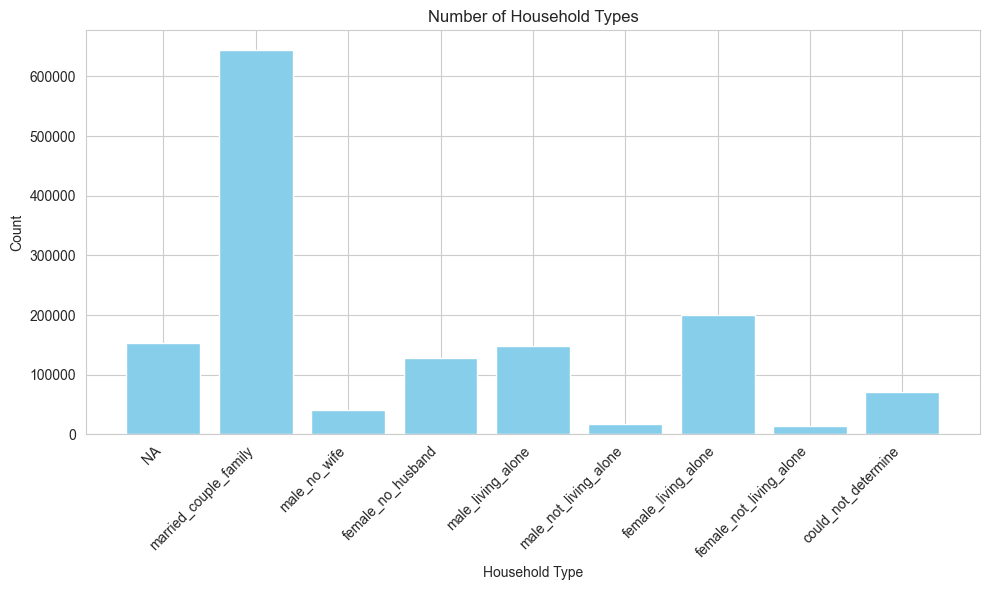

<Figure size 640x480 with 0 Axes>

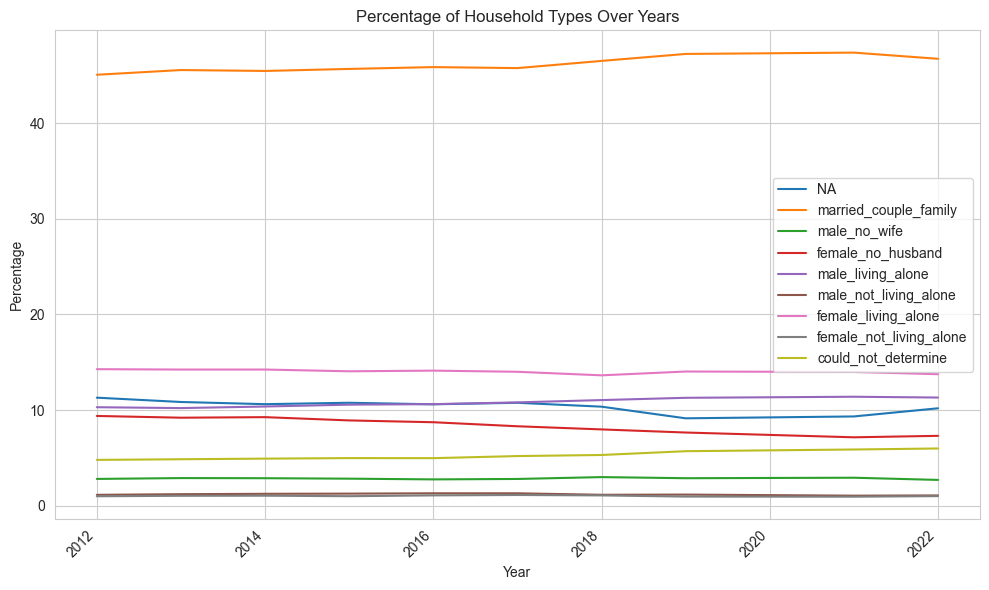

Number of Nulls: 223236
Number of NA: 152989
Number of Could not be determined: 70247


In [ ]:
#Number of Household Types 
temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "NFAMS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count Total 
count = spark.sql("""
    SELECT 
           SUM(CASE WHEN HHTYPE = 0 THEN 1 ELSE 0 END) as NA,
           SUM(CASE WHEN HHTYPE = 1 THEN 1 ELSE 0 END) as married_couple_family,
           SUM(CASE WHEN HHTYPE = 2 THEN 1 ELSE 0 END) as male_no_wife,
           SUM(CASE WHEN HHTYPE = 3 THEN 1 ELSE 0 END) as female_no_husband,
           SUM(CASE WHEN HHTYPE = 4 THEN 1 ELSE 0 END) as male_living_alone,
           SUM(CASE WHEN HHTYPE = 5 THEN 1 ELSE 0 END) as male_not_living_alone,
           SUM(CASE WHEN HHTYPE = 6 THEN 1 ELSE 0 END) as female_living_alone,
           SUM(CASE WHEN HHTYPE = 7 THEN 1 ELSE 0 END) as female_not_living_alone,
           SUM(CASE WHEN HHTYPE = 9 THEN 1 ELSE 0 END) as could_not_determine
    FROM temp
""")

count_pd = count.toPandas()
household_types = ['NA', 'married_couple_family', 'male_no_wife', 'female_no_husband',
                   'male_living_alone', 'male_not_living_alone', 'female_living_alone',
                   'female_not_living_alone', 'could_not_determine']
count_values = [count_pd[col].iloc[0] for col in household_types]

## Count per year 
count_by_year = spark.sql("""
    SELECT 
           YEAR,
           SUM(CASE WHEN HHTYPE = 0 THEN 1 ELSE 0 END) as NA,
           SUM(CASE WHEN HHTYPE = 1 THEN 1 ELSE 0 END) as married_couple_family,
           SUM(CASE WHEN HHTYPE = 2 THEN 1 ELSE 0 END) as male_no_wife,
           SUM(CASE WHEN HHTYPE = 3 THEN 1 ELSE 0 END) as female_no_husband,
           SUM(CASE WHEN HHTYPE = 4 THEN 1 ELSE 0 END) as male_living_alone,
           SUM(CASE WHEN HHTYPE = 5 THEN 1 ELSE 0 END) as male_not_living_alone,
           SUM(CASE WHEN HHTYPE = 6 THEN 1 ELSE 0 END) as female_living_alone,
           SUM(CASE WHEN HHTYPE = 7 THEN 1 ELSE 0 END) as female_not_living_alone,
           SUM(CASE WHEN HHTYPE = 9 THEN 1 ELSE 0 END) as could_not_determine
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")
count_by_year_pd = count_by_year.toPandas()


# Plotting the bar chart of each household type overall 
plt.figure(figsize=(10, 6))
plt.bar(household_types, count_values, color='skyblue')
plt.title('Number of Household Types')
plt.xlabel('Household Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
first_plot = plt.gcf()

# Plotting the line chart for each household type per year as percent
total_count_by_year = count_by_year_pd.drop(columns='YEAR').sum(axis=1)
for household_type in household_types:
    count_by_year_pd[household_type] = (count_by_year_pd[household_type] / total_count_by_year) * 100

plt.figure(figsize=(10, 6))
for household_type in household_types:
    plt.plot(count_by_year_pd['YEAR'], count_by_year_pd[household_type], label=household_type)
plt.title('Percentage of Household Types Over Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Number of Nulls:", int(count_pd['NA'] + count_pd['could_not_determine']))
print("Number of NA:", int(count_pd['NA']))
print("Number of Could not be determined:", int(count_pd['could_not_determine']))


The majority of households are married couples followd by females living alone and males living alone. The distribution of household types is consistent over time. A signitifcant portion of households, 223,236 answered either NA or could not be determined. 

Distribution of Number of Families per Household per year


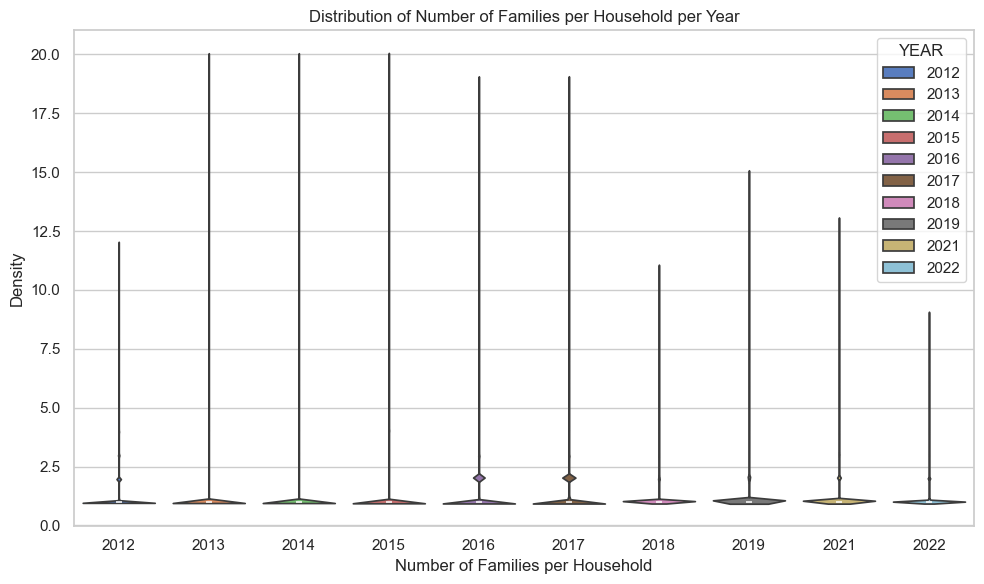

In [ ]:
#Look at distribution of families per household 
temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "NFAMS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
nfams_categories = df_hh.select("NFAMS").distinct().rdd.flatMap(lambda x: x).sortBy(lambda x: x).collect()

sql_query = "SELECT YEAR,"
for nfams_category in nfams_categories:
    sql_query += f" SUM(CASE WHEN NFAMS = {nfams_category} THEN 1 ELSE 0 END) as NFAMS_{nfams_category},"
sql_query = sql_query[:-1]  # Remove the trailing comma
sql_query += " FROM temp GROUP BY YEAR ORDER BY YEAR"


nfams_counts_per_year = spark.sql(sql_query)
print("Distribution of Number of Families per Household per year")
#nfams_counts_per_year.show()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.violinplot(data=temp.toPandas(), x="YEAR", y="NFAMS", palette="muted", hue="YEAR")
plt.title("Distribution of Number of Families per Household per Year")
plt.xlabel("Number of Families per Household")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

The majority of households are single family homes and occurence of n number of families decreases as n increases. There are some outliers of 10-20 families in a single home each year. These are most likely real households and will have to be further investigated. 

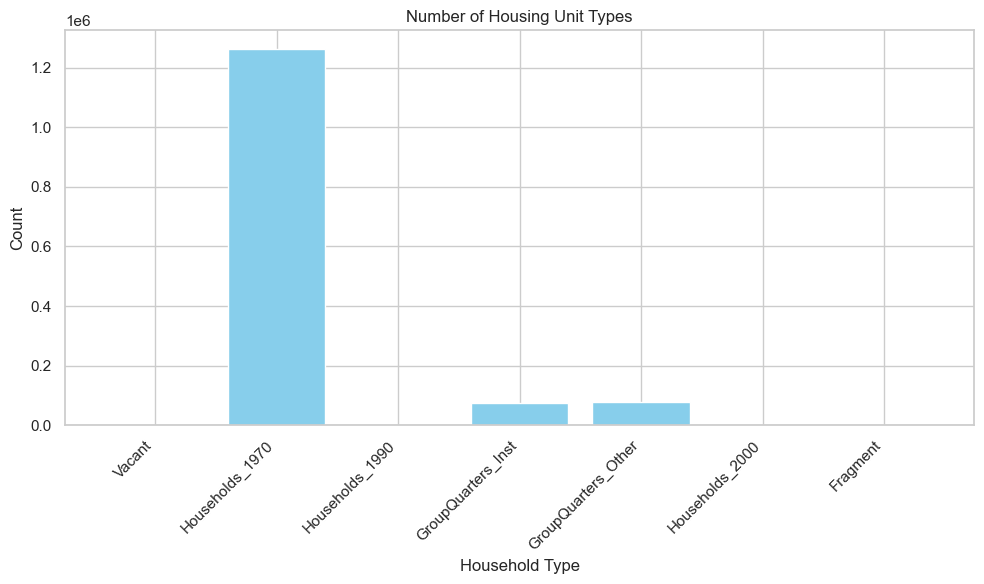

<Figure size 640x480 with 0 Axes>

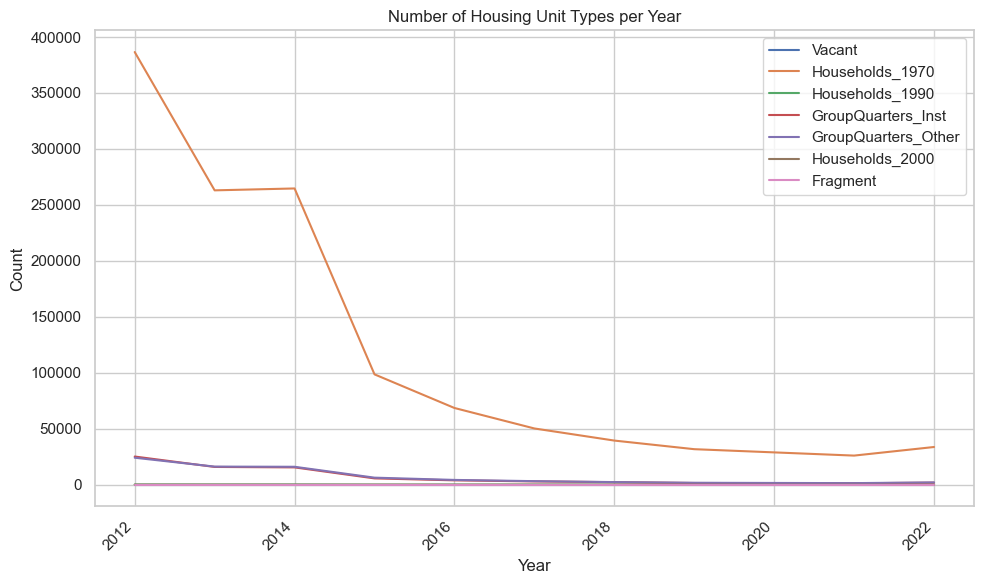

,Vacant,Households_1970,Households_1990,GroupQuarters_Inst,GroupQuarters_Other,Households_2000,Fragment
0,0,1262339,662,75691,77298,36,0


In [ ]:
#Number of Families with GC
temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "GQ").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count Total 
count = spark.sql("""
    SELECT 
        SUM(CASE WHEN GQ = 0 THEN 1 ELSE 0 END) as Vacant,
        SUM(CASE WHEN GQ = 1 THEN 1 ELSE 0 END) as Households_1970,
        SUM(CASE WHEN GQ = 2 THEN 1 ELSE 0 END) as Households_1990,
        SUM(CASE WHEN GQ = 3 THEN 1 ELSE 0 END) as GroupQuarters_Inst,
        SUM(CASE WHEN GQ = 4 THEN 1 ELSE 0 END) as GroupQuarters_Other,
        SUM(CASE WHEN GQ = 5 THEN 1 ELSE 0 END) as Households_2000,
        SUM(CASE WHEN GQ = 6 THEN 1 ELSE 0 END) as Fragment
    FROM temp
""")

count_pd = count.toPandas()
qc_types = ['Vacant', 'Households_1970', 'Households_1990', 'GroupQuarters_Inst',
                   'GroupQuarters_Other', 'Households_2000', 'Fragment']
count_values = [count_pd[col].iloc[0] for col in qc_types]

## Count by Year 
count_yr = spark.sql("""
    SELECT 
        YEAR,
        SUM(CASE WHEN GQ = 0 THEN 1 ELSE 0 END) as Vacant,
        SUM(CASE WHEN GQ = 1 THEN 1 ELSE 0 END) as Households_1970,
        SUM(CASE WHEN GQ = 2 THEN 1 ELSE 0 END) as Households_1990,
        SUM(CASE WHEN GQ = 3 THEN 1 ELSE 0 END) as GroupQuarters_Inst,
        SUM(CASE WHEN GQ = 4 THEN 1 ELSE 0 END) as GroupQuarters_Other,
        SUM(CASE WHEN GQ = 5 THEN 1 ELSE 0 END) as Households_2000,
        SUM(CASE WHEN GQ = 6 THEN 1 ELSE 0 END) as Fragment
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")

count_yr_pd = count_yr.toPandas()

# Plotting the bar chart of each household type overall 
plt.figure(figsize=(10, 6))
plt.bar(qc_types, count_values, color='skyblue')
plt.title('Number of Housing Unit Types')
plt.xlabel('Household Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
first_plot = plt.gcf()

# Plotting the line chart for each household type per year 
plt.figure(figsize=(10, 6))
for qc_type in qc_types:
    plt.plot(count_yr_pd['YEAR'], count_yr_pd[qc_type], label=qc_type)

plt.title('Number of Housing Unit Types per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
line_plot = plt.gcf()

#Display Plots 
plt.show()

count_pd

Most households represented in this datasrt fall into the 1970 catagorization of household with ~150,000 group quarters. There is ~700 households that fall into the 1990 and 2000 household classifications. For further analysis all household classifications may have to be catagorized together due to the small sample size of 1990 and 2000 classifications. 

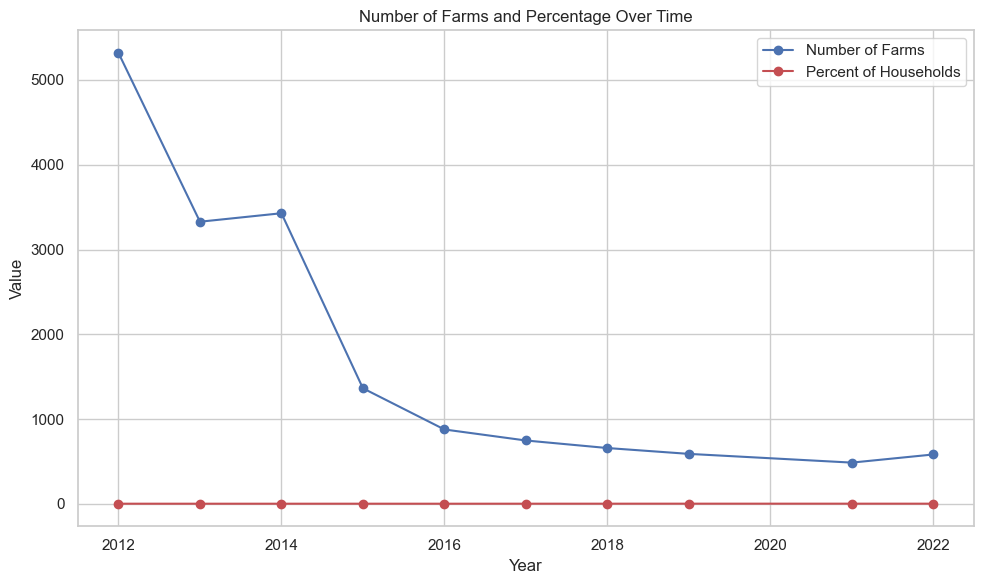

In [ ]:
#Farms 
temp = df_hh.select("SERIAL","YEAR", "FARM").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count Total 
## Count by Year 
count_yr = spark.sql("""
    SELECT 
        YEAR,
        SUM(CASE WHEN FARM = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN FARM = 1 THEN 1 ELSE 0 END) as NonFarm,
        SUM(CASE WHEN FARM = 2 THEN 1 ELSE 0 END) as Farm,
        SUM(CASE WHEN FARM = 3 THEN 1 ELSE 0 END) as Blank
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")

count_yr_pd = count_yr.toPandas()
count_yr_pd['Total'] = count_yr_pd.sum(axis=1)
count_yr_pd['Percent'] = round((count_yr_pd['Farm'] / count_yr_pd['Total'])*100, 2)
count_yr_pd

plt.figure(figsize=(10, 6))
plt.plot(count_yr_pd['YEAR'], count_yr_pd['Farm'], marker='o', linestyle='-', color='b', label='Number of Farms')
plt.plot(count_yr_pd['YEAR'], count_yr_pd['Percent'], marker='o', linestyle='-', color='r', label='Percent of Households')
plt.title('Number of Farms and Percentage Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The number of farms has decreased over time. However the percent of farms relative to households per year is fairly consistent. 

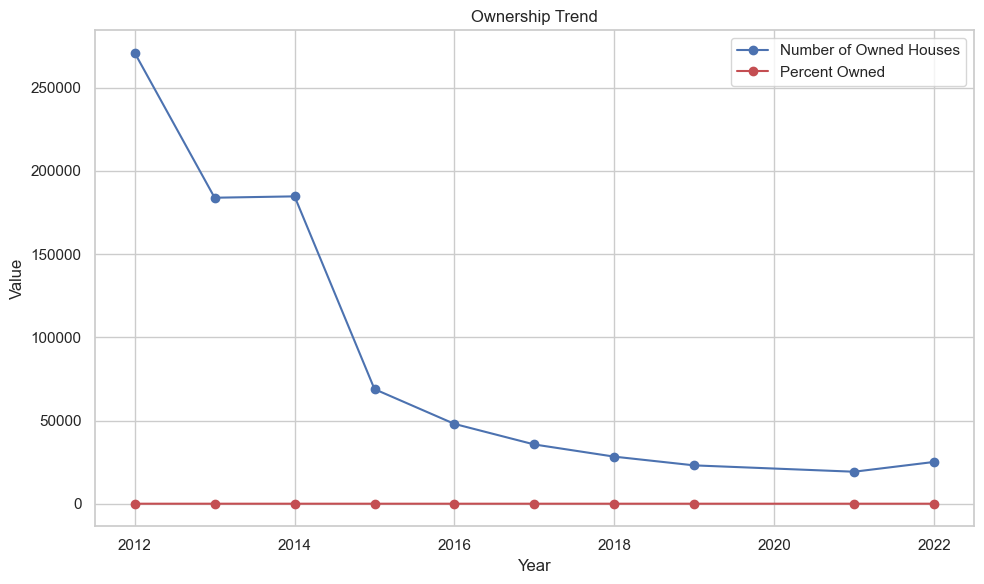

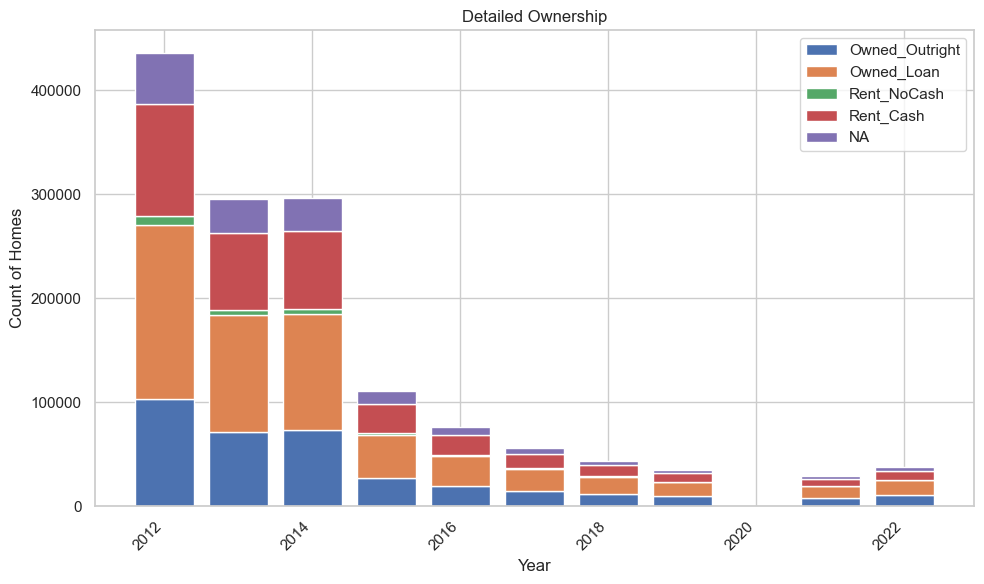

In [ ]:
#Ownership  
temp = df_hh.select("SERIAL","YEAR", "OWNERSHP", "OWNERSHPD").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count of Ownership by Year 
count_yr = spark.sql("""
    SELECT 
        YEAR,
        SUM(CASE WHEN OWNERSHP = 0 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN OWNERSHP = 1 THEN 1 ELSE 0 END) as Owned,
        SUM(CASE WHEN OWNERSHP = 2 THEN 1 ELSE 0 END) as Rented
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")

count_yr_pd = count_yr.toPandas()
count_yr_pd['Total'] = count_yr_pd.sum(axis=1)
count_yr_pd['Percent'] = round((count_yr_pd['Owned'] / count_yr_pd['Total'])*100, 2)
count_yr_pd

plt.figure(figsize=(10, 6))
plt.plot(count_yr_pd['YEAR'], count_yr_pd['Owned'], marker='o', linestyle='-', color='b', label='Number of Owned Houses')
plt.plot(count_yr_pd['YEAR'], count_yr_pd['Percent'], marker='o', linestyle='-', color='r', label='Percent Owned')
plt.title('Ownership Trend')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Detailed Ownership 
count_yr = spark.sql("""
    SELECT 
        YEAR,
        SUM(CASE WHEN OWNERSHPD = 00 THEN 1 ELSE 0 END) as NA,
        SUM(CASE WHEN OWNERSHPD = 10 THEN 1 ELSE 0 END) as Owned,
        SUM(CASE WHEN OWNERSHPD = 11 THEN 1 ELSE 0 END) as Checkmark,
        SUM(CASE WHEN OWNERSHPD = 12 THEN 1 ELSE 0 END) as Owned_Outright,
        SUM(CASE WHEN OWNERSHPD = 13 THEN 1 ELSE 0 END) as Owned_Loan,
        SUM(CASE WHEN OWNERSHPD = 20 THEN 1 ELSE 0 END) as Rented,
        SUM(CASE WHEN OWNERSHPD = 21 THEN 1 ELSE 0 END) as Rent_NoCash,
        SUM(CASE WHEN OWNERSHPD = 22 THEN 1 ELSE 0 END) as Rent_Cash
    FROM temp
    GROUP BY YEAR
    ORDER BY YEAR
""")

count_yr_pd = count_yr.toPandas()
own_types = ['Owned_Outright', 'Owned_Loan', 'Rent_NoCash', 'Rent_Cash', 'NA']
plt.figure(figsize=(10, 6))
bottom = None
for own_type in own_types:
    if bottom is None:
        plt.bar(count_yr_pd['YEAR'], count_yr_pd[own_type], label=own_type)
        bottom = count_yr_pd[own_type]
    else:
        plt.bar(count_yr_pd['YEAR'], count_yr_pd[own_type], bottom=bottom, label=own_type)
        bottom += count_yr_pd[own_type]
plt.title('Detailed Ownership')
plt.xlabel('Year')
plt.ylabel('Count of Homes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Display Plots 
plt.show()


The number of owned houses has increase. However the percent of owned housed of all households per year is consistent. Further investigation will have to determine how the decreased number of households correlates with ownership. We see a similar patter with the more detailed ownership categories. 

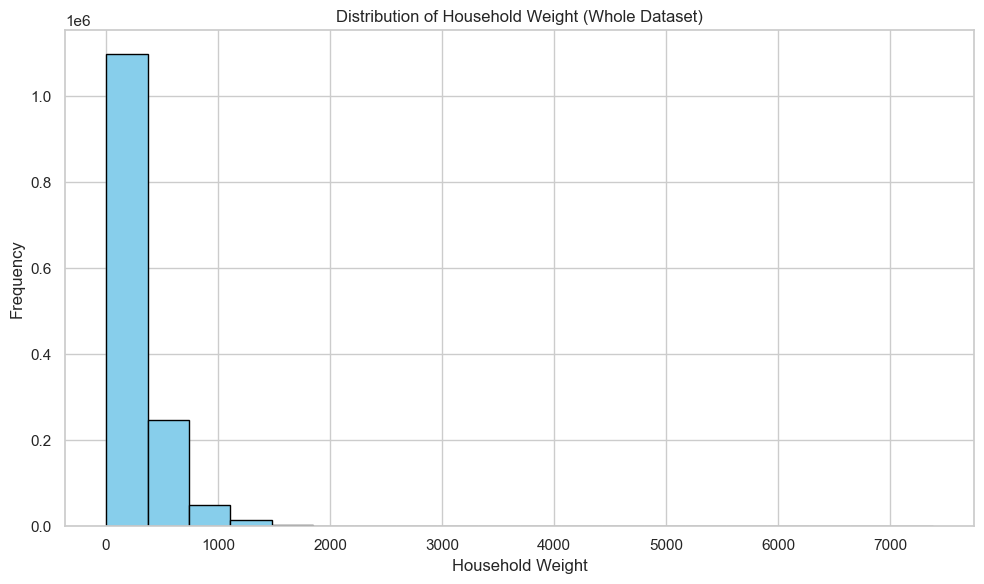

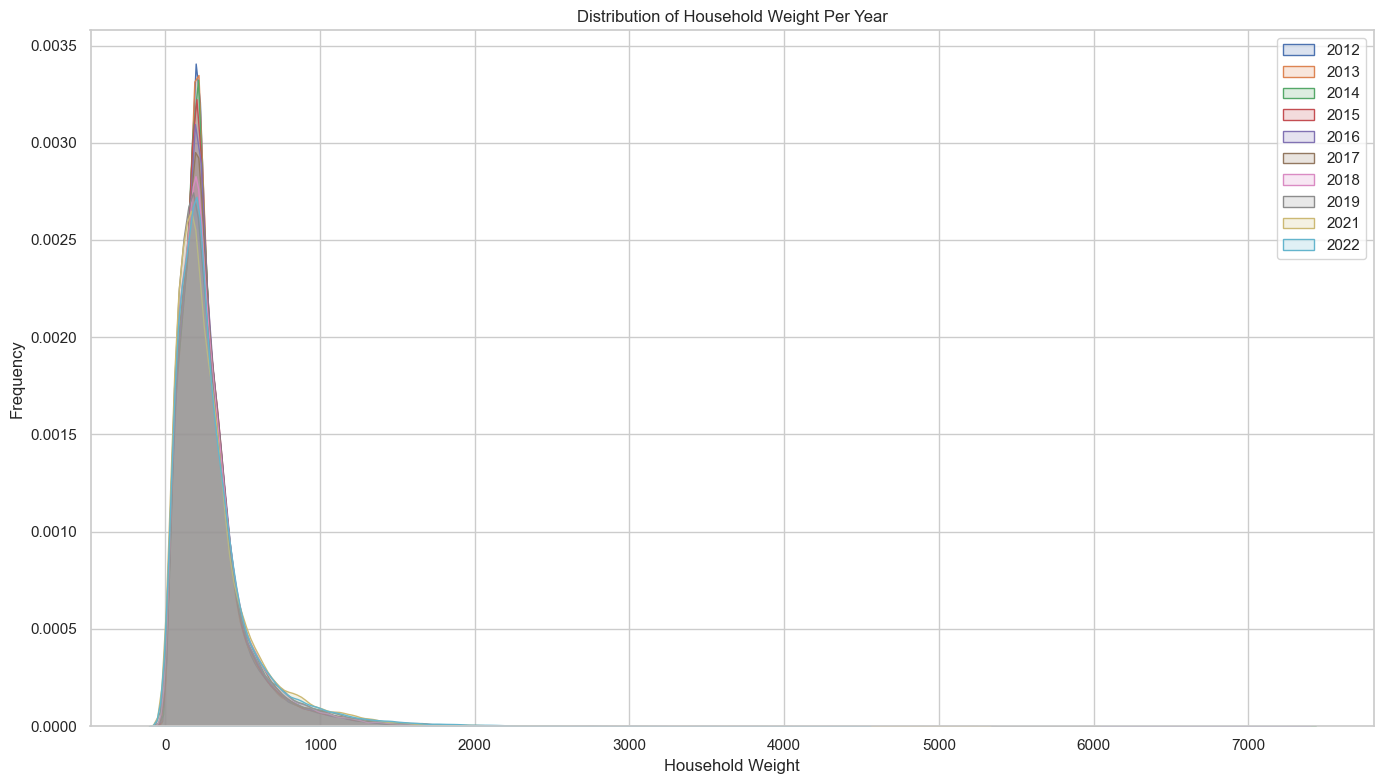

In [ ]:
## Look at household weight 
temp = df_hh.select("SERIAL", "YEAR", "HHWT").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

# Plot distribution of HHWT over the whole dataset
plt.figure(figsize=(10, 6))
plt.hist(df_pd["HHWT"], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Household Weight (Whole Dataset)')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot distribution of HHWT per year
years = df_pd["YEAR"].unique()
bottom = None
plt.figure(figsize=(14, 8))
for year in years:
    df_year = df_pd[df_pd["YEAR"] == year]
    sns.kdeplot(df_year["HHWT"], label=str(year), fill=True, alpha=0.2)
plt.title('Distribution of Household Weight Per Year')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Household weights appear to have a similar distribution each year. It appears to be normally distributed with a right hand tail representing very common populations. 

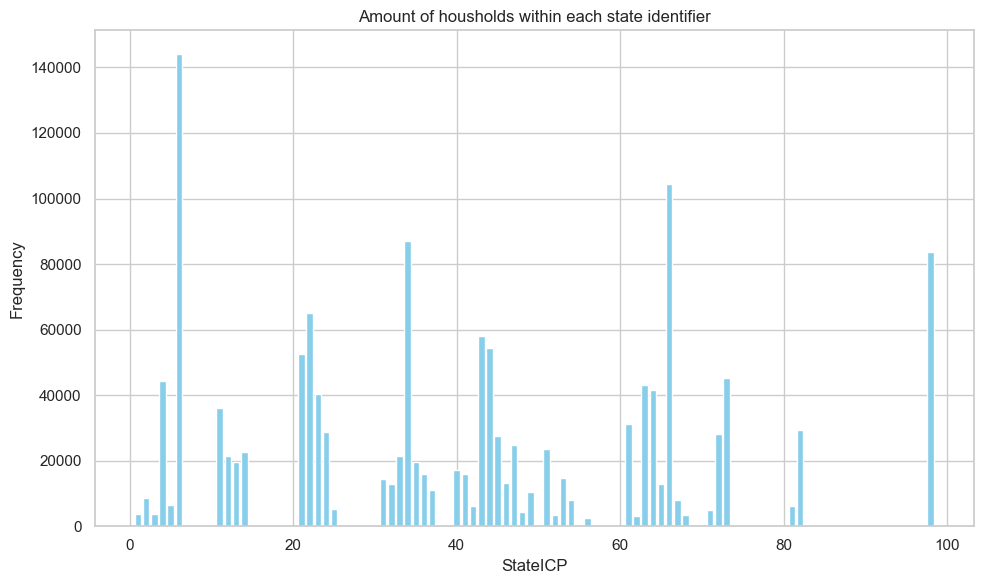

STATEICP
71    144109
49    104367
43     86935
13     83538
25     65056
Name: SERIAL, dtype: int64


In [ ]:
#Explore Geograpic Variables
temp = df_hh.select("SERIAL", "YEAR", "STATEICP").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

#all STATEICP values 
icp_values = df_pd['STATEICP'].unique()

#Amount of serial that correspond to each STATEICP
count_values = df_pd.groupby('STATEICP')['SERIAL'].count()

# Plot distribution of STATEICP over the whole dataset
plt.figure(figsize=(10, 6))
plt.bar(icp_values, count_values, color='skyblue')
#plt.hist(df_pd["STATEICP"], bins=20, color='skyblue', edgecolor='black')
plt.title('Amount of housholds within each state identifier')
plt.xlabel('StateICP')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

print(count_values.nlargest(5))

It appears that there is a concentration among where residents live. With the largest density is ICP values 71 and 49.

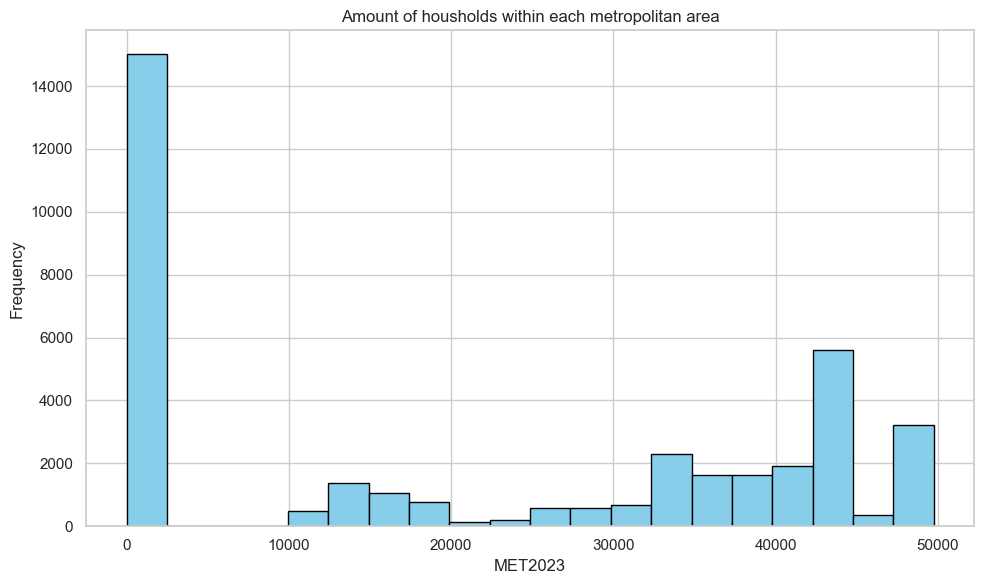

In [ ]:
temp = df_hh.select("SERIAL", "YEAR", "MET2023").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()
#MET2023: (Metropolitan area (2023 delineations, identifiable areas only)) Numeric identifier of metropolitan areas.
cleaned = df_pd.dropna()

# Plot distribution of MET2023 over the whole dataset
plt.figure(figsize=(10, 6))
#plt.bar(icp_values, count_values, color='skyblue')
plt.hist(cleaned["MET2023"], bins=20, color='skyblue', edgecolor='black')
plt.title('Amount of housholds within each metropolitan area')
plt.xlabel('MET2023')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

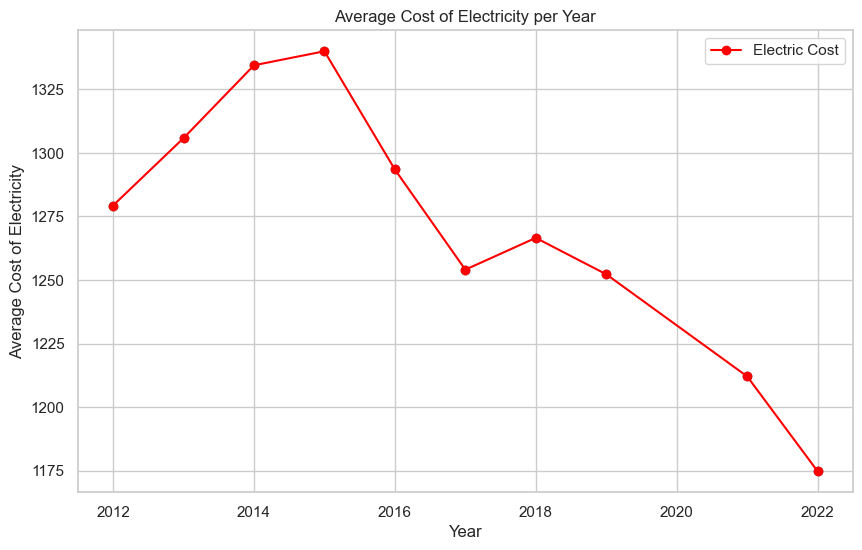

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "ACOSTELEC").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

average_cost_per_year = df_pd.groupby('YEAR')['ACOSTELEC'].mean()

# Reset the index to convert the result to a DataFrame for easier plotting
average_cost_per_year_df = average_cost_per_year.reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTELEC'])
plt.title('Average Cost of Electricity per Year')
plt.xlabel('Year')
plt.ylabel('Average Cost of Electricity')
plt.plot(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTELEC'], color='red', linestyle='-', marker='o', label = 'Electric Cost')
plt.grid(True)
plt.legend()
plt.show()

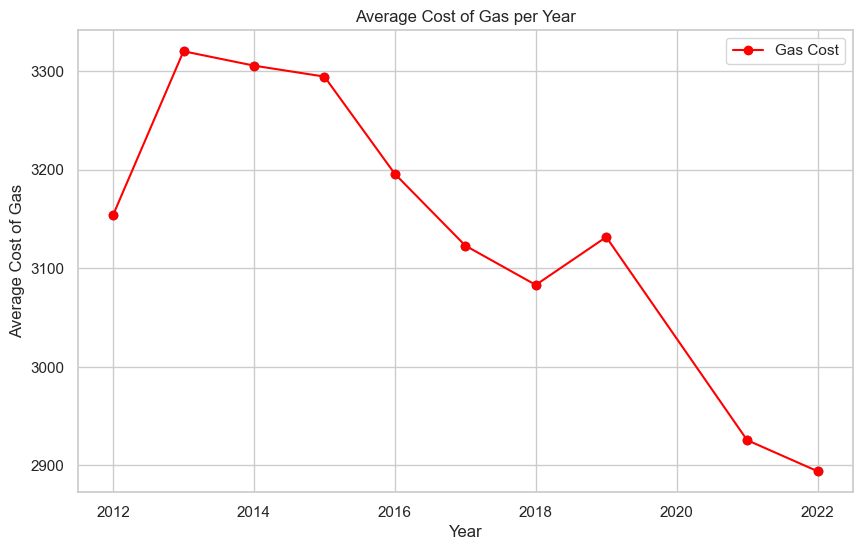

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "ACOSTGAS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

average_cost_per_year = df_pd.groupby('YEAR')['ACOSTGAS'].mean()

# Reset the index to convert the result to a DataFrame for easier plotting
average_cost_per_year_df = average_cost_per_year.reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTGAS'])
plt.title('Average Cost of Gas per Year')
plt.xlabel('Year')
plt.ylabel('Average Cost of Gas')
plt.plot(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTGAS'], color='red', linestyle='-', marker='o', label = 'Gas Cost')
plt.grid(True)
plt.legend()
plt.show()

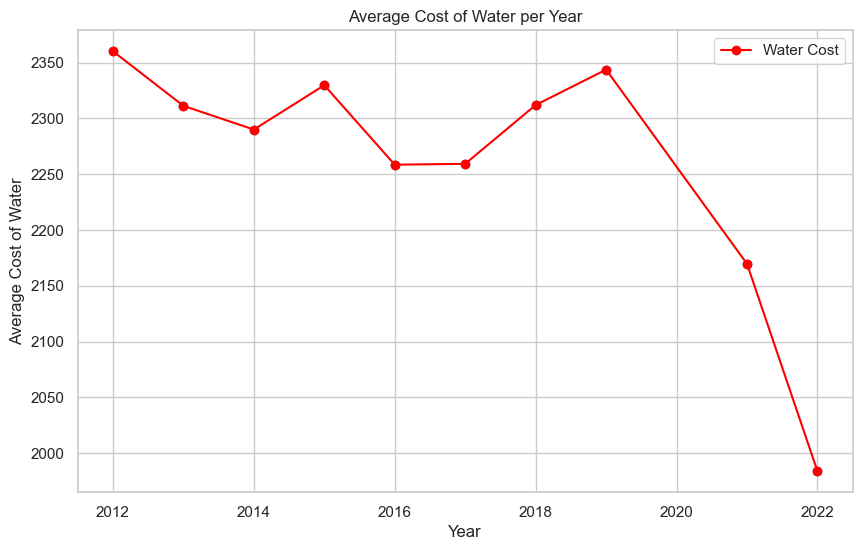

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "ACOSTWATR").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

average_cost_per_year = df_pd.groupby('YEAR')['ACOSTWATR'].mean()

# Reset the index to convert the result to a DataFrame for easier plotting
average_cost_per_year_df = average_cost_per_year.reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTWATR'])
plt.title('Average Cost of Water per Year')
plt.xlabel('Year')
plt.ylabel('Average Cost of Water')
plt.plot(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTWATR'], color='red', linestyle='-', marker='o', label = 'Water Cost')
plt.grid(True)
plt.legend()
plt.show()

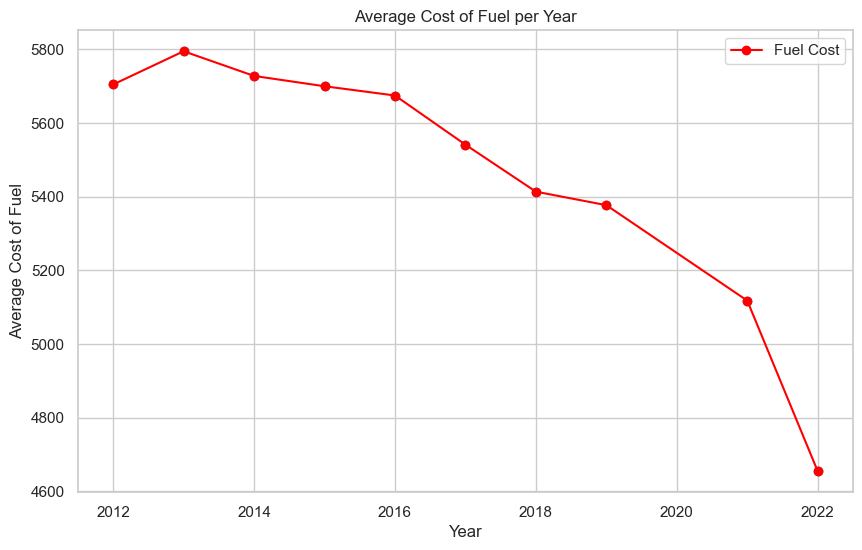

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "ACOSTFUEL").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

average_cost_per_year = df_pd.groupby('YEAR')['ACOSTFUEL'].mean()

# Reset the index to convert the result to a DataFrame for easier plotting
average_cost_per_year_df = average_cost_per_year.reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTFUEL'])
plt.title('Average Cost of Fuel per Year')
plt.xlabel('Year')
plt.ylabel('Average Cost of Fuel')
plt.plot(average_cost_per_year_df['YEAR'], average_cost_per_year_df['ACOSTFUEL'], color='red', linestyle='-', marker='o', label = 'Fuel Cost')
plt.grid(True)
plt.legend()
plt.show()

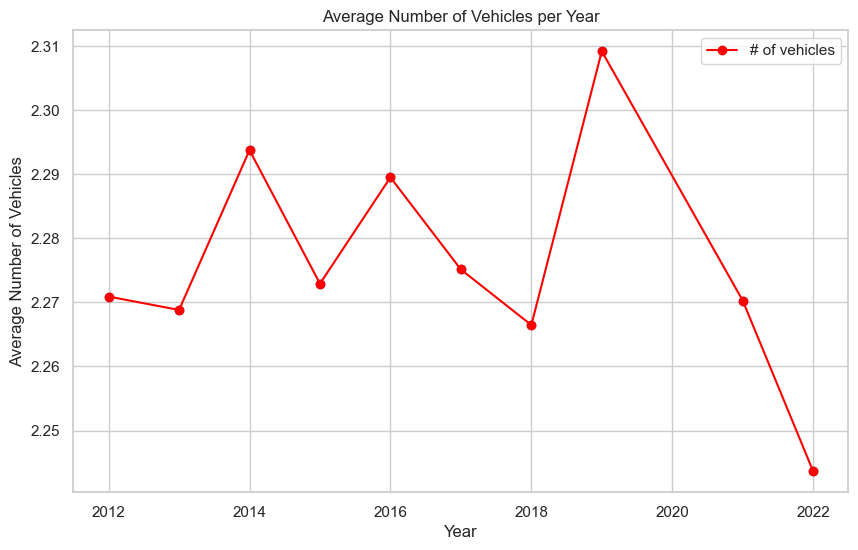

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "VEHICLES").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

average_cost_per_year = df_pd.groupby('YEAR')['VEHICLES'].mean()

# Reset the index to convert the result to a DataFrame for easier plotting
average_cost_per_year_df = average_cost_per_year.reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_cost_per_year_df['YEAR'], average_cost_per_year_df['VEHICLES'])
plt.title('Average Number of Vehicles per Year')
plt.xlabel('Year')
plt.ylabel('Average Number of Vehicles')
plt.plot(average_cost_per_year_df['YEAR'], average_cost_per_year_df['VEHICLES'], color='red', linestyle='-', marker='o', label = '# of vehicles')
plt.grid(True)
plt.legend()
plt.show()

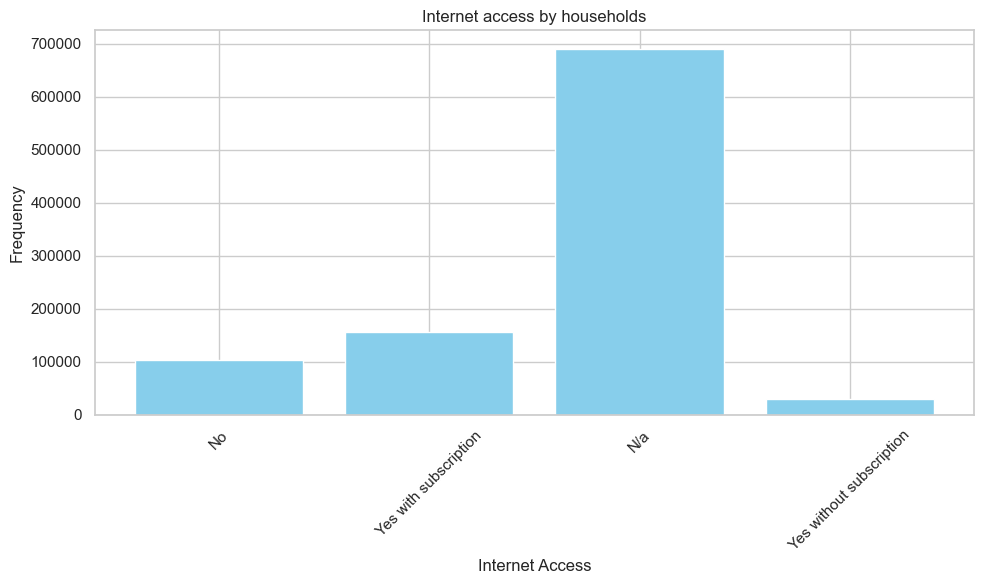

In [ ]:
temp = df_hh.select("SERIAL","YEAR", "CINETHH").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()
cleaned = df_pd.dropna()

cleaned['CINETHH'] = cleaned['CINETHH'].map({
    0: 'N/a',
    1: 'Yes with subscription',
    2: 'Yes without subscription',
    3: 'No'
})

icp_values = cleaned['CINETHH'].unique()

#Amount of serial that correspond to each CINETHH
count_values = cleaned.groupby('CINETHH')['SERIAL'].count()

# Plot distribution of STATEICP over the whole dataset
plt.figure(figsize=(10, 6))
plt.bar(icp_values, count_values, color='skyblue')
#plt.hist(df_pd["STATEICP"], bins=20, color='skyblue', edgecolor='black')
plt.title('Internet access by households')
plt.xticks(icp_values, rotation=45)
plt.xlabel('Internet Access')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

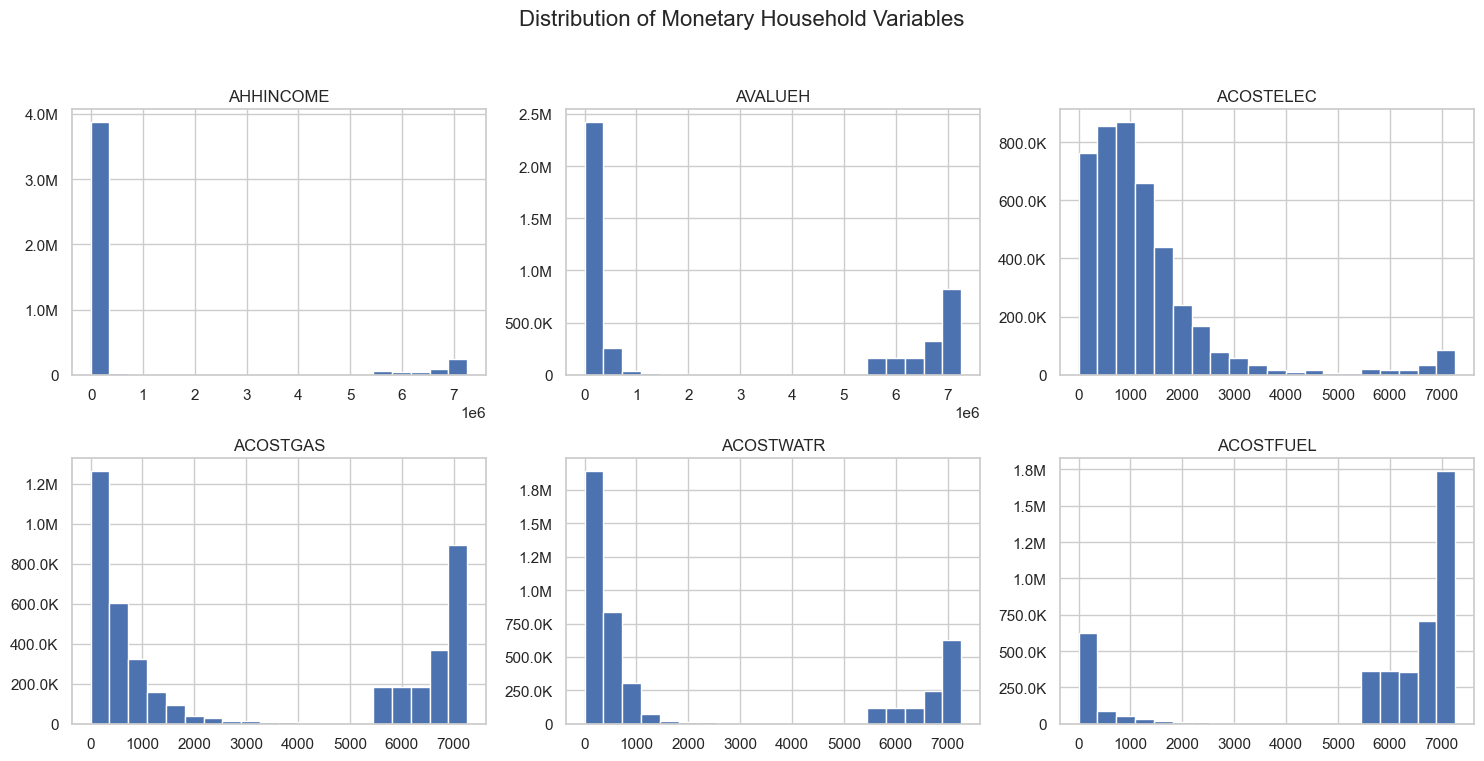

In [ ]:
#Plot Distrubution of Happiness Variables

warnings.filterwarnings("ignore")

hh_var = df_hh.columns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

#Loop through each subplot
for i in range(6):
    ax = axes[i]
    j = i + 25
    hist(ax, df_hh.select(F.col(hh_var[j])), bins=20)
    ax.set_title(f"{hh_var[j]}")  # Adding title to each subplot



fig.suptitle("Distribution of Monetary Household Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Text(0.5, 0.98, 'Distribution of HH Income below 200k and Home Value below 800k')

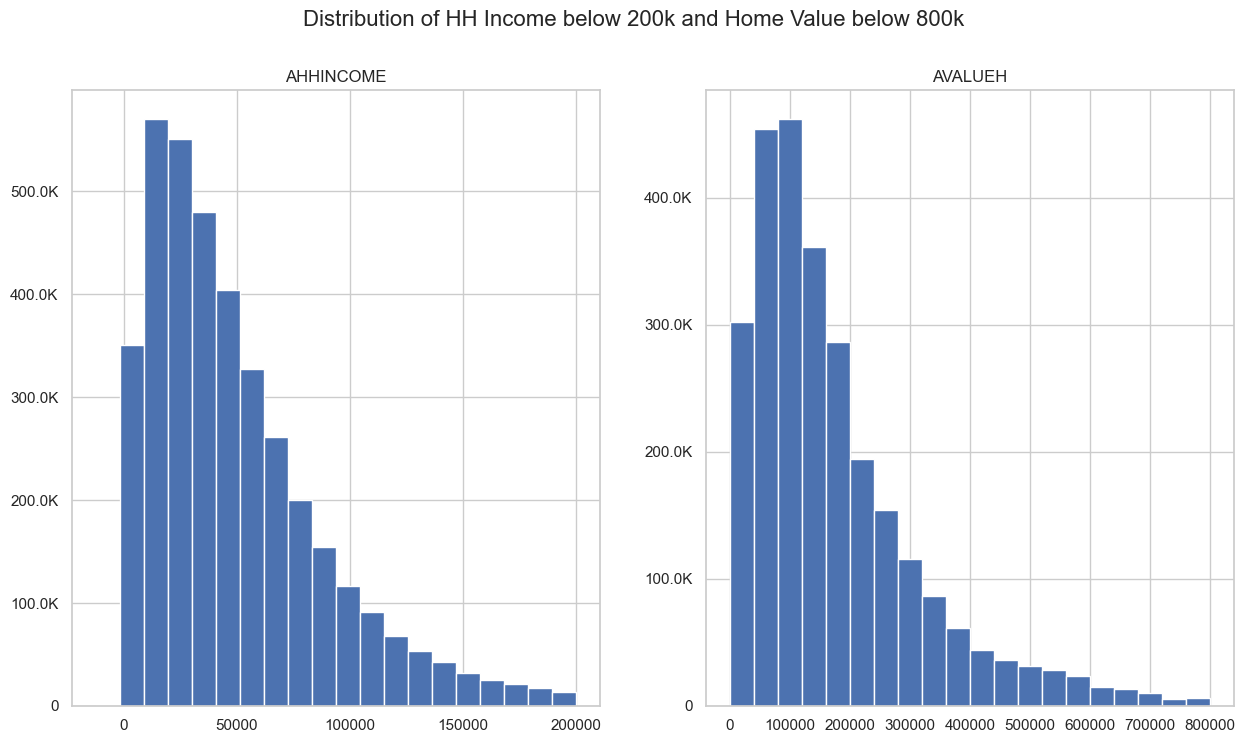

In [ ]:

df_income_filtered = df_hh.filter(df_hh.AHHINCOME < 200000)
df_hvalue_filtered = df_hh.filter(df_hh.AVALUEH < 800000)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes = axes.flatten()

hist(axes[0], df_income_filtered.select(F.col(hh_var[25])), bins=20)
hist(axes[1], df_hvalue_filtered.select(F.col(hh_var[26])), bins=20)

axes[0].set_title(f"{hh_var[25]}")
axes[1].set_title(f"{hh_var[26]}")
fig.suptitle("Distribution of HH Income below 200k and Home Value below 800k", fontsize=16)

We see some interesting distributions here, however this is close to what is expected. The wealthy minority is causing the majority of the abnormal distributions. As we can see above, filtering out the outliers shows a more reasonable distribution.

#### Household Census Variables 
The household census dataset contails 31 variables and 10,002,255 instances over a 10 year period. Each year has a similar number of instance approximately 1,000,000 for each year. The dataset include 1,416,026 household with the number of household decreaseing over time. **EXPLANATION FOR NUM OF HOUSEHOLDS DECREASING OVER TIME**

##### Technical Variables 
*   **YEAR**: This data set represents year ranging from 2012 - 2022 exluding 2020. 2020 was excluding due to potential data acquring and difference due to the COVID-19 pandemic. 
*   **SAMPLE**: (IPUMS sample identifier) Sample identifier specific to source of dataset. This data was gathered from 10 different source dataset, a dataset for each year. 
*   **SERIAL**: (Household serial number) Unique identifier for each household in the census across years. Although the dataset is composed of 10,002,255 individuals, it reprents only 1,416,026 differnt households. The difference is due to multiple individuals residing in the same household. All 10 million individuals are analyzed individually in the individual dataset. 
*   **CBSERIAL**: (Original Census Bureau household serial number) Unique identifier assigned by the creators of the census to uniquely identify each household. The CBSerial number provided the same patterns as the SERIAL variable. 
*   **HHWT**: (Household weight) The household weight indicates how many household in the US this samples represents in a sample of 1000 households. This variable is key in ensuring our analysis of a sample is representative on the national level. The weights are normally distributed with a right tail across the whole data and shows a similar patter on each year. The right tail is expected is most likely some very common prevalent populations within the US.
*   **HHTYPE**: (Household Type) Household types is a catagorical variable represented by digits 0-8, and 9.
      0. N/A <br>
      1. married-couple family household <br>
      2. Male household, no wife present <br>
      3. Female household, no husband present
      4. Male household, living alone
      5. Male household, not living alone
      6. Female household, living alone
      7. female household, not living alone  
      9. could not be determined <br>
      Married couple household represent the majority of household followed by females living alone and males living alone. 223236 householed were not categorized; 152989 of which this question was not applicable to and 70247 of which could not be determined. There is a consistent distribution of each household type across over time. 
*   **CLUSTER**: (Household cluster for variance estimation) Clusters using Taylor series linear approximation for use with Strava. Will be ignored. Each household has a unique cluster number and since we are not using Strava, we will not be using this variable. 
*   **CPI99**: (CPI-U adjustment factor to 1999 dollars) This is a mutliplier available to convert dollar figures to the dollar amount in 2000 census ensuring dollar figures are comparables between years. It was utilized to covert all monetary values. 
*   **STRATA**: (Household strata for variance estimation) Correction of complex samples for Cluster variable. Since we are not using Strava, we will not be using this variable.

##### Geographic Variables
*   **STATEICP**: (State (ICPSR code)) State Identifier with digit codes. 
*   **MET2023**: (Metropolitan area (2023 delineations, identifiable areas only)) Numeric identifier of metropolitan areas. 

##### Economic Characteristics 
*   **MOBLHOME**: (Annual mobile home costs)
*   **TAXINCL**: (Mortgage payment includes property taxes) This variable indicated whether mortgage payments include tax (0: N/a, 1: No, 2: Yes)
*   **INSINCL**: (Mortgage payment includes property insurance) This variable indicated whether mortgage payments include insurance (0: N/a, 1: No, 2: Yes)
*   **RENTGRS**: (Monthly gross rent) Monthly gross rent included rental cost including utilities and fuels. This value is not adjusted for inflation and needs to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **CONDOFEE**: (Monthly condominium fee) The condoninium feed reports the monthly fee of the condo including maintenance, administrative and improvement costs. It additionaly may include utilities and fuel. It is not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **MOBLHOME**: (Annual mobile home costs) This cost report the annual amount of cost incurred by owners expluding any loan installments which are reported in MOBLHOME2.

      **How is this displayed?? NEEDS CORRECTION**

*   **HHINCOME**: (Total household income) Total household income reports the total income of all household members over the age of 15 and is not adjusted for inflation. The income of heads of the households is reported in FTOTINC. 

      **How is this displayed?? NEEDS CORRECTION**

*   **FOODSTMP**: (Food stamp recipiency) Food stamps is a catagorical variable indicating whether anyone in the household recieved food stamps. 
      0. N/a
      1. No
      2. Yes
*   **VALUEH**: (House value) House value is reported without adjustment for inflation and is impacted by changes in methods of determining house values. 

      **How is this displayed?? NEEDS CORRECTION**


##### Appliance, Mechanical, Other Variables 
*   **COSTELEC**: (Annual electricity cost) Electricity cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTGAS**: (Annual gas cost) Gas cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTWATR**: (Annual water cost) Water cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTFUEL**: (Annual home heating fuel cost) Heating cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **CINETHH**: (Access to internet) Internet reports if any member of the household has access to the internet. 
      0. N/a
      1. Yes with subscription 
      2. Yes without subscription 
      3. No 
*   **VEHICLES**: (Vehicles available) Vehicles reports the number of cars, vans or trucks are kept at the home by members of the household. 

##### Houshold Composition Variables 
*   **GQ**: (Group quarters status) Group quarties is a catagorical variable to catagorize housing units into households, group quarters or vacant units.The groups are represented by digits 0-6. 
      0. Vacant unit
      1. Household under 1970 definiton
      2. Additional households under 1990 definition
      3. Group quarters
      4. Other group quarters
      5. Additional households under 2000 definition 
      6. Fragment <br>
      Most households fall into the 1970 classification of households with ~150,000 group quarters. There is ~700 households that fall into the 1990s and 2000 definition of households. Due to the samll sample size, all household classifications may need to be grouped together. 
*   **FARM**: (Farm status) Farm status is a catagorical variable represented by digits. 
      0. n/a
      1. Non-Farm
      2. Farm
      9. Blank/missing <br>
      The number of farms has decreased over time. However the percent of farms relative to households per year is fairly consistent. 
*   **OWNERSHP**: (Ownership of dwelling (tenure) [general version])
      0. n/a
      1. Owned or being bought (loan)
      2. Rented <br>
      The number of owned houses has increase. However the percent of owned housed of all households per year is consistent. Further investigation will have to determine how the decreased number of households correlates with ownership. 
*   **OWNERSHPD**: (Ownership of dwelling (tenure) [detailed version]) <br>
       00. N/a <br>
       10. Owned or being bought <br>
       11. Check mark (owns?) <br>
       12. Owned free and clear <br>
       13. Owned with mortgage or loan <br>
       20. Rented <br>
       21. No cash rent <br>
       22. With cash rent <br>
       Similar to the ownership of simpler ownership categories in variable (OWNERSHP), we see a decrease in quantity but a consistent relative levels of ownership. 
*   **COUPLETYPE**: (Householder couple type) Couple type reports the relantionship of the householder. 
      0. n/a
      1. Heterosexual married couple 
      2. Homosexual married couple
      3. Heterosexual unmarried couple 
      4. Homosexual unmarried couple <br>
      Due to the limited years of availabilty (2019, 2021, & 2022) for couple type categories, we will not be able to include this variable in further analysis.  
*   **NFAMS**: (Number of families in household). The number of families within a household is reported numerically. Family is defined as any group who is related by blood, adoption, or marriage. Unrelated individuals are considered a seperate family. Most households are single families and the occurence of n families per household decreases as n increase. The are outlier households with up to 20 families in one household per year. Thse cases will have to be investigated to determine whether they are genuine cases or technical outliers. 


## Data Preprossesing 
##### Variable Normalization, Encoding & Feature Expansion 

Note: Normalization of monetary values for inflation was performed in import dataset section 

### Individual Census Data

id_norm is the new normalized spark rdd 

In [8]:
# Create a new column "FULLTIME" if the individual works 40+ hours per week

df_id = df_id.withColumn('FULLTIME',
    F.when((F.col("UHRSWORK") >= 40), 1)\
    .otherwise(0))

In [9]:
#Recoding 

#LOOKING: combine not reported and n/a
df_idN = df_id.withColumn("LOOKING", when(df_id["LOOKING"] == 3, 0).otherwise(df_id["LOOKING"])) 
#Group Quarters: Combine Household types and Group Quarter Types 
df_idN = df_idN.withColumn("GQ", when(df_idN["GQ"] == 2, 1).when(df_idN["GQ"] == 5, 1).when(df_idN["GQ"] == 4, 3).otherwise(df_idN["GQ"]))

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'PERNUM', 'CBPERNUM', 'CLUSTER', 'CPI99', 'STRATA',
              'PERWT', 'RACED', 'EDUCD', 'EMPSTATD', 'CLASSWKRD']
df_idN = df_idN.drop(*var_remove)

#Normalize Columns 
columns = df_idN.columns

# Define UDF to convert vector to array
def vector_to_array(v):
    return v.toArray().tolist()
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Function to scale a single column
def scale_column(df, input_col):
    assembler = VectorAssembler(inputCols=[input_col], outputCol=f"{input_col}_vec")
    scaler = MinMaxScaler(inputCol=f"{input_col}_vec", outputCol=f"{input_col}_scaled_vec")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df)
    df = df.withColumn(f"{input_col}_scaled", vector_to_array_udf(col(f"{input_col}_scaled_vec"))[0])
    df = df.drop(f"{input_col}_vec", f"{input_col}_scaled_vec")
    df = df.drop(input_col).withColumnRenamed(f"{input_col}_scaled", input_col)
    return df

# # Scale each column individually
for col_name in columns:
    if isinstance(df_idN.schema[col_name].dataType, NumericType):
        id_norm = scale_column(df_idN, col_name)

### Household Census Data

hh_norm is the new normalized spark rdd 

In [10]:
#Recoding 
#Group Quarters: Combine Household types and Group Quarter Types 
df_hhN = df_hh.withColumn("GQ", when(df_hh["GQ"] == 2, 1).when(df_hh["GQ"] == 5, 1).when(df_hh["GQ"] == 4, 3).otherwise(df_hh["GQ"]))
#Household Types: combine NA and could not be determined
df_hhN = df_hhN.withColumn("HHTYPE", when(df_hhN["HHTYPE"] == 9, 0).otherwise(df_hhN["HHTYPE"]))
#Fix CINETHH None values with Na encoded as 0 
df_hhN = df_hhN.na.fill(value=0, subset=['CINETHH'])

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'CPI99', 'STRATA',
              'MET2023', 'TAXINCL', 'INSINCL', 'COUPLETYPE']
df_hhN = df_hhN.drop(*var_remove)

# Create a new column for all Utilities by combining individual costs of gas, electricity, fuel, and water
# and drop old columns

df_hhN = df_hhN.withColumn('COSTUTIL', 
                         df_hhN['ACOSTELEC'] + df_hhN['ACOSTGAS'] + df_hhN["ACOSTWATR"] + df_hhN['ACOSTFUEL'])

df_hhN = df_hhN.drop('ACOSTELEC', 'ACOSTGAS', 'ACOSTWATR', 'ACOSTFUEL')

# Define UDF to convert vector to array
def vector_to_array(v):
    return v.toArray().tolist()
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
# Function to scale a single column
def scale_column(df, input_col):
    print(f"Scaling column: {input_col}")
    assembler = VectorAssembler(inputCols=[input_col], outputCol=f"{input_col}_vec")
    scaler = MinMaxScaler(inputCol=f"{input_col}_vec", outputCol=f"{input_col}_scaled_vec")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df)
    df = df.withColumn(f"{input_col}_scaled_array", vector_to_array_udf(col(f"{input_col}_scaled_vec")))
    df = df.withColumn(f"{input_col}_scaled", col(f"{input_col}_scaled_array")[0])
    df = df.drop(f"{input_col}_vec", f"{input_col}_scaled_vec", f"{input_col}_scaled_array")
    df = df.drop(input_col).withColumnRenamed(f"{input_col}_scaled", input_col)
    return df
# Scale each column individually if it is numeric
hh_norm = df_hhN
columns = df_hhN.columns
for col_name in columns:
    if isinstance(df_hhN.schema[col_name].dataType, NumericType):
        hh_norm = scale_column(hh_norm, col_name)

Scaling column: YEAR
Scaling column: HHTYPE
Scaling column: STATEICP
Scaling column: GQ
Scaling column: FARM
Scaling column: OWNERSHP
Scaling column: OWNERSHPD
Scaling column: FOODSTMP
Scaling column: CINETHH
Scaling column: VEHICLES
Scaling column: NFAMS
Scaling column: ARENTGRS
Scaling column: ACONDOFEE
Scaling column: AMOBLHOME
Scaling column: AHHINCOME
Scaling column: AVALUEH
Scaling column: COSTUTIL


### Split test/train data

In [ ]:
# Split datasets into train and test

id_norm_train, id_norm_test = id_norm.randomSplit(weights=[0.8,0.2], seed=200)
hh_norm_train, hh_norm_test = hh_norm.randomSplit(weights=[0.8,0.2], seed=200)


DataFrame[YEAR: double, HHTYPE: double, STATEICP: double, GQ: double, FARM: double, OWNERSHP: double, OWNERSHPD: double, FOODSTMP: double, CINETHH: double, VEHICLES: double, NFAMS: double, ARENTGRS: double, ACONDOFEE: double, AMOBLHOME: double, AHHINCOME: double, AVALUEH: double, COSTUTIL: double, features: vector]

## Model 

## Household Census KMeans 

In [ ]:
# Create "features" columns for pyspark ML models

hh_norm_columns = hh_norm_train.columns

vecAssembler = VectorAssembler(inputCols=hh_norm_columns, outputCol="features")
new_hh_df = vecAssembler.transform(hh_norm_train)
new_hh_df.cache()

NameError: name 'hh_norm_train' is not defined

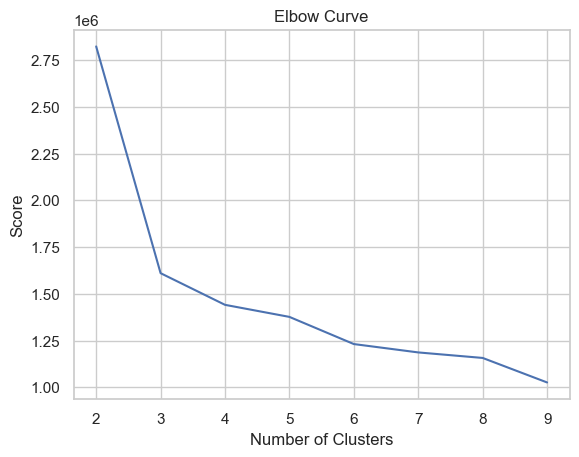

In [ ]:
# FInd the best number of k clusters

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_hh_df)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
hh_k = 3
hh_kmeans = KMeans().setK(hh_k).setSeed(1).setFeaturesCol('features')
hh_model = hh_kmeans.fit(new_hh_df)

# Get cluster centers
hh_centers = hh_model.clusterCenters()

print("Cluster Centers: ")
for center in hh_centers:
    print(center)

# Add cluster predictions to the dataframe
hh_transformed_df = model.transform(new_hh_df)

# Show some examples of the data with cluster predictions
hh_transformed_df.select("features", "prediction").show(10)

Cluster Centers: 
[0.47582961 0.31128803 0.4021302  0.         0.01618887 0.5
 0.57242113 0.06112318 0.37657197 0.26396562 0.00206897 0.
 0.00624566 0.0023468  0.01085264 0.02830107 0.42008608]
[4.62309735e-01 4.39088110e-01 4.25332480e-01 0.00000000e+00
 4.00992644e-03 9.99984239e-01 9.97021435e-01 2.33569248e-01
 4.26805889e-01 3.27461625e-01 5.79809127e-03 1.26774103e-01
 6.29313191e-08 0.00000000e+00 6.63649747e-03 9.27325176e-01
 5.68558768e-01]
[0.47761017 0.         0.39665999 1.         0.         0.
 0.         0.08900205 0.         0.         0.         0.
 0.         0.         0.92369682 0.92356407 0.        ]
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[3,14,15],[1....|         6|
|(17,[2,3,14,15],[...|         6|
|(17,[2,3,14,15],[...|         6|
|(17,[2,3,14,15],[...|        

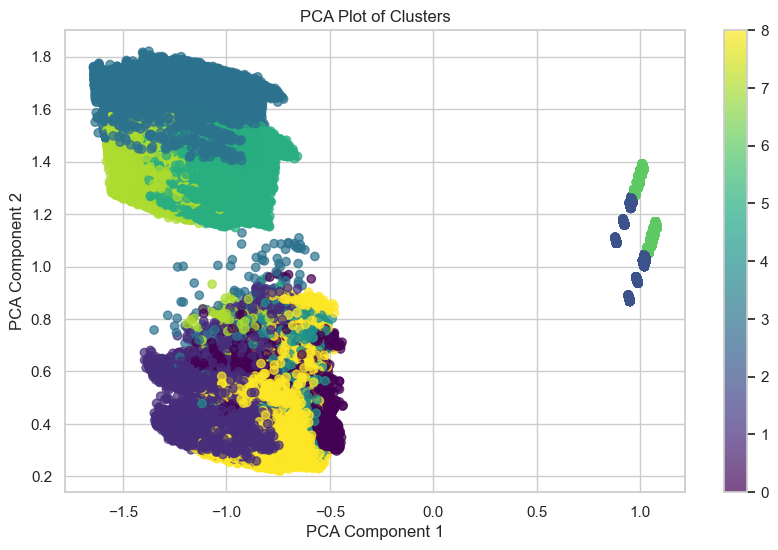

In [ ]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(hh_transformed_df)
pca_result = model.transform(hh_transformed_df).select("pcaFeatures", "prediction")

# Collect the PCA result and cluster predictions
pca_result_pd = pca_result.toPandas()
pca_features = np.array(pca_result_pd['pcaFeatures'].tolist())
predictions = pca_result_pd['prediction'].tolist()

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=predictions, cmap='viridis', marker='o', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Clusters')

plt.colorbar()
plt.show()

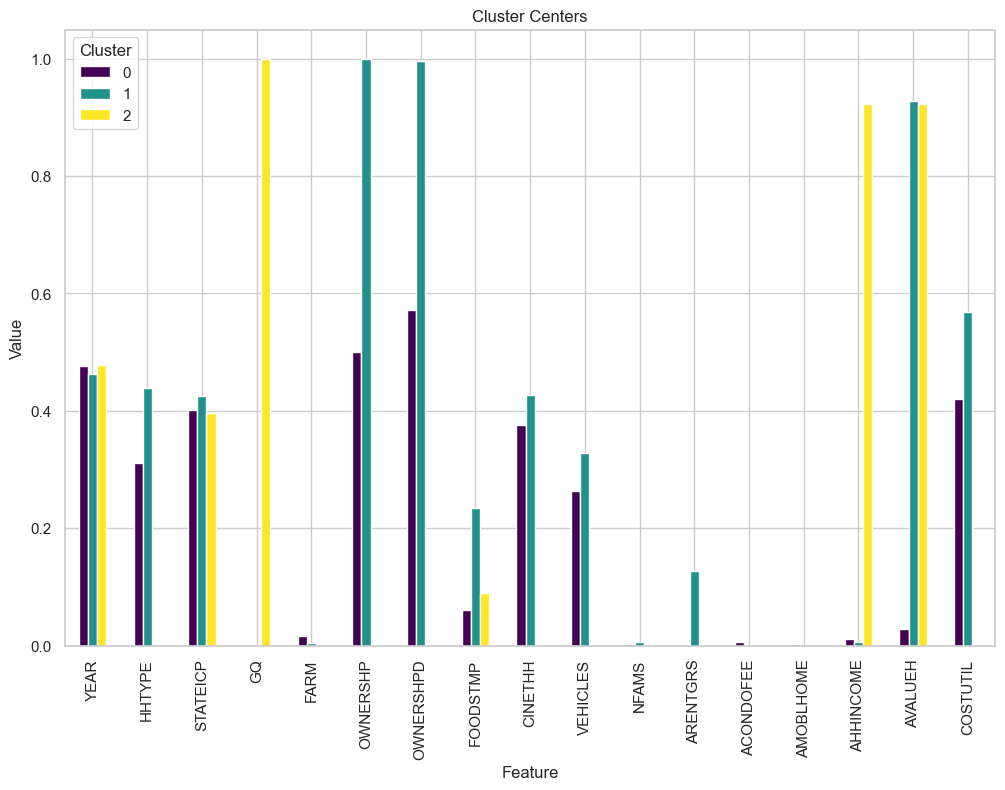

In [ ]:
# Get cluster centers

# Convert to a DataFrame for easy plotting
centers_df = pd.DataFrame(hh_centers, columns=hh_norm_columns)
#Export cluster to csv for analysis outside SDSC 
centers_df.to_csv('hh_clusters', index=False)

# Plot cluster centers
centers_df.T.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Cluster Centers')
plt.legend(title='Cluster')
plt.show()

Cluster 0: Household who own the home 

Cluster 1: Household who Rent 

Cluster 2: Group Quarters
- Household Income is much higher which makes sense considering more people live in a home. 

In [ ]:
# Create a ClusteringEvaluator to evaluate clustering by silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')

# Calculate silhouette score
silhouette = evaluator.evaluate(hh_transformed_df)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.35122424918265777


The Cluster Center plots show the average values for each feature for the three clusters identified. Each bar represents a feature and its height reflects the mean value of that feature within the cluster. K-means idenified three clusters: households who own, households who rent and group quarters. 

The silhouette score is 0.351 indicating the clusters are not well-defined and distinct from each other. This may be becuase there are household who are similar for oher metrics between owner and renters. Increasing the groups may allow for more distinct similar groups. 

Based on this analysis K-means may not be a good model for clustering this dataset. Alternatively, pre-selection of features may allow for more distinct clusters. 

## Individual Census KMeans

In [ ]:
# Create "features" columns for id_norm_train

id_norm_columns = id_norm_train.columns

id_norm_columns.remove('EMPSTATD_str')

vecAssembler_id = VectorAssembler(inputCols=id_norm_columns, outputCol="features")
new_id_df = vecAssembler_id.transform(id_norm_train)
new_id_df.cache()

DataFrame[YEAR: int, GQ: int, FAMSIZE: int, SEX: int, AGE: int, MARST: int, RACE: int, CITIZEN: int, HCOVANY: int, SCHOOL: int, EDUC: int, SCHLTYPE: int, EMPSTAT: int, CLASSWKR: int, UHRSWORK: int, LOOKING: int, POVERTY: int, AINCTOT: double, AFTOTINC: double, AINCWELFR: double, AINCINVST: double, EMPSTATD_str: string, FULLTIME: double, features: vector]

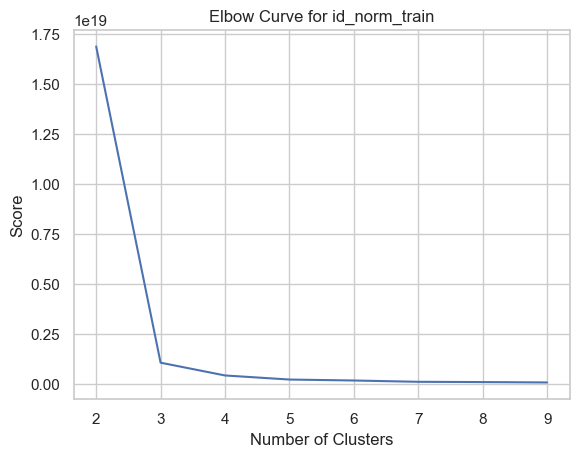

In [ ]:
# FInd the best number of k clusters

# Calculate cost and plot for id_norm_train
cost_id = np.zeros(10)
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_id_df)
    cost_id[k] = model.summary.trainingCost

# Plot the cost for id_norm_train
df_cost_id = pd.DataFrame(cost_id[2:])
df_cost_id.columns = ["cost"]
new_col_id = [2, 3, 4, 5, 6, 7, 8, 9]
df_cost_id.insert(0, 'cluster', new_col_id)

pl.plot(df_cost_id.cluster, df_cost_id.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve for id_norm_train')
pl.show()

In [ ]:
id_k = 3
id_kmeans = KMeans().setK(id_k).setSeed(1).setFeaturesCol('features')
id_model = id_kmeans.fit(new_id_df)

# Get cluster centers
id_centers = id_model.clusterCenters()

print("Cluster Centers: ")
for center in id_centers:
    print(center)

# Add cluster predictions to the dataframe
id_transformed_df = model.transform(new_id_df)

# Show some examples of the data with cluster predictions
id_transformed_df.select("features", "prediction").show(10)

Cluster Centers: 
[2.01672438e+03 1.00000000e+00 2.84280570e+00 1.52180879e+00
 4.87229219e+01 3.00127490e+00 1.85809197e+00 3.48996087e-01
 1.90750479e+00 1.12137525e+00 7.23674918e+00 1.14330547e+00
 1.76953271e+00 1.35590453e+00 2.41060201e+01 4.44868811e-01
 3.34721351e+02 2.85515460e+04 6.31624639e+04 2.88535701e+01
 1.69512315e+03 4.36343937e-01]
[2.01656827e+03 1.00724787e+00 4.55030750e+00 1.48871629e+00
 7.31658938e+00 6.00000000e+00 2.31400642e+00 8.06807221e-02
 1.95113264e+00 1.55830802e+00 9.97313688e-01 1.67369511e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.81332501e+02 6.73897029e+06 1.39942237e+05 6.73890357e+04
 6.73896422e+05 0.00000000e+00]
[2.01677845e+03 3.00000000e+00 1.00000000e+00 1.40752645e+00
 4.19671562e+01 5.25821949e+00 1.95050434e+00 2.19761996e-01
 1.79739710e+00 1.35292958e+00 5.99849934e+00 1.49869907e+00
 2.59625806e+00 9.29844572e-01 1.12450998e+01 3.62004531e-01
 0.00000000e+00 5.81408667e+03 6.70492114e+06 4.88955141e+01
 2.

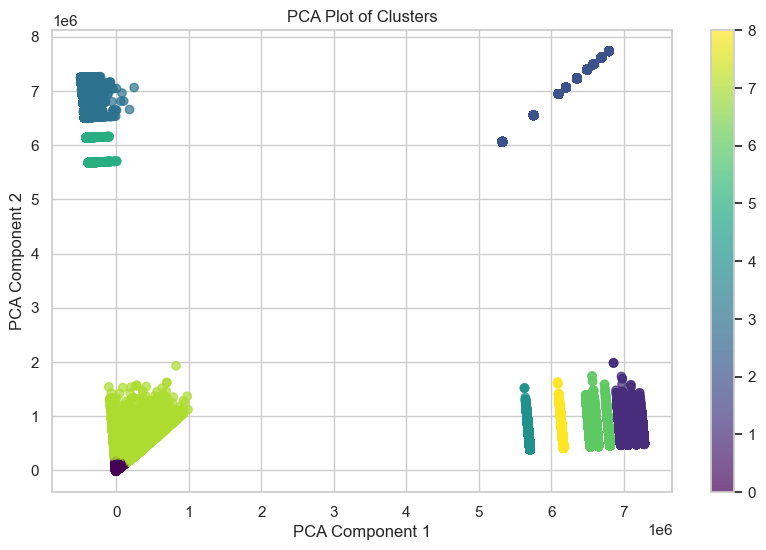

In [ ]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(id_transformed_df)
pca_result = model.transform(id_transformed_df).select("pcaFeatures", "prediction")

# Collect the PCA result and cluster predictions
pca_result_pd = pca_result.toPandas()
pca_features = np.array(pca_result_pd['pcaFeatures'].tolist())
predictions = pca_result_pd['prediction'].tolist()

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=predictions, cmap='viridis', marker='o', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Clusters')

plt.colorbar()
plt.show()

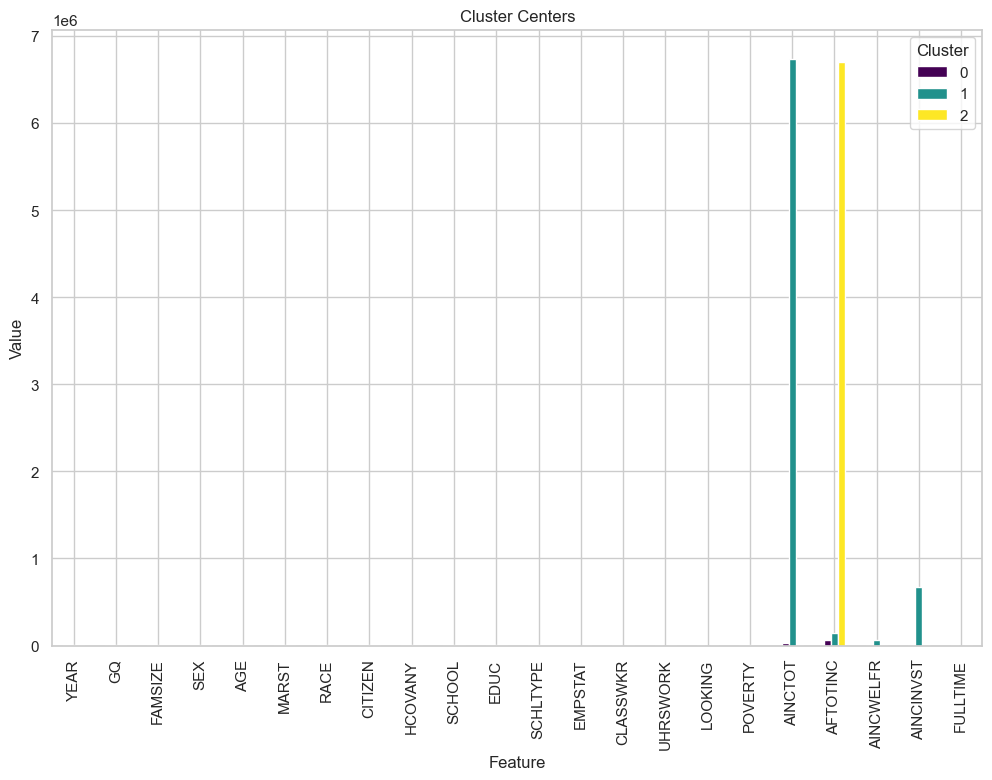

In [ ]:
# Get cluster centers

# Convert to a DataFrame for easy plotting
centers_df = pd.DataFrame(id_centers, columns=id_norm_columns)

# Plot cluster centers
centers_df.T.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Cluster Centers')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Create a ClusteringEvaluator to evaluate clustering by silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')

# Calculate silhouette score
silhouette = evaluator.evaluate(id_transformed_df)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.8820288782270599


The Cluster Centers plot shows the average values of each feature for the three identified clusters. Each bar represents a feature, and its height reflects the mean value of that feature within the cluster. The features include demographic, socio-economic, and health-related variables. Notably, variables such as AINCTOT (total income), AFTOTINC (family total income), and POVERTY show significant differences across clusters, indicating that income and poverty status are key distinguishing factors among the clusters.

The silhouette score is 0.869, which is quite high. A high silhouette score close to 1 indicates that the clusters are well-defined and distinct from each other. The points within each cluster are very similar to each other and different from points in other clusters. The clustering model has successfully grouped the data points into clusters that have high internal similarity and low external similarity.

Based on the analysis and visualizations, KMeans appears to be a good model for clustering this dataset. The high silhouette score of 0.869 indicates that the clusters are well-defined and distinct from each other, with data points closer to their assigned cluster centers compared to other clusters. The PCA plot further supports this, showing clear separation between clusters in a two-dimensional space. The cluster centers plot reveals meaningful differences across several features, particularly income-related variables. Together, these findings suggest that KMeans effectively captures the underlying structure of the data, making it a suitable model for identifying and analyzing patterns within the dataset.

## Household Decision Tree

In [12]:
#Split unnormalized data 
hh_train, hh_test = df_hhN.randomSplit(weights=[0.8,0.2], seed=200)

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [14]:
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") > 0)).count())
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") == 0)).count())

0
2757352


Adjusted gross rent will be removed since it is not collected for owned homes. 

In [15]:
features = hh_train.columns
features.remove("OWNERSHPD")
features.remove("OWNERSHP")
features.remove('ARENTGRS')

In [16]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(hh_train)
dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")
model = dt_classifier.fit(data)

In [ ]:
#predictions_train = model.transform(data)
test_data = assembler.transform(hh_test)
predictions_test = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

#accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

#print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.9990159327876406


In [ ]:
feature_importance = model.featureImportances.toArray()

# Show feature importance
for i, column in enumerate(assembler.getInputCols()):
    print(f"Feature '{column}': {feature_importance[i]:.2f}")

Feature 'YEAR': 0.02
Feature 'HHTYPE': 0.00
Feature 'STATEICP': 0.00
Feature 'GQ': 0.29
Feature 'FARM': 0.00
Feature 'FOODSTMP': 0.00
Feature 'CINETHH': 0.00
Feature 'VEHICLES': 0.00
Feature 'NFAMS': 0.00
Feature 'ACONDOFEE': 0.00
Feature 'AMOBLHOME': 0.00
Feature 'AHHINCOME': 0.00
Feature 'AVALUEH': 0.69
Feature 'COSTUTIL': 0.00


In [ ]:
#print(tree_structure)

In [ ]:
# Mapping of features
feature_mapping = {
    0: "YEAR",
    1: "HHTYPE",
    2: "STATEICP",
    3: "GROUP_QUARTERS",
    4: "FARM",
    5: "FOODSTMP",
    6: "CINETHH",
    7: "VEHICLES",
    8: "NFAMS",
    9: "ACONDOFEE",
    10: "AMOBLHOME",
    11: "AHHINCOME",
    12: "HOUSE_VALUE",
    13: "COSTUTIL"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_22f4e8275e1b, depth=4, numNodes=9, numClasses=3, numFeatures=14
  If (HOUSE_VALUE <= 1243301.0)
   Predict: Own
  Else (HOUSE_VALUE > 1243301.0)
   If (GROUP_QUARTERS <= 2.0)
    If (HOUSE_VALUE <= 5919999.408)
     If (YEAR <= 2021.5)
      Predict: Own
     Else (YEAR > 2021.5)
      Predict: Rent
    Else (HOUSE_VALUE > 5919999.408)
     Predict: Rent
   Else (GROUP_QUARTERS > 2.0)
    Predict: Na



In [ ]:
#rent = hh_test.filter(col("OWNERSHP") == 2).count()
#total = hh_test.count()
print("Percent Rented:", (rent/total)*100)
gc = hh_test.filter(col("GQ") > 2).count()
print("Percent Group Quarters:", (gc/total)*100)

Percent Rented: 26.23318411158071


Percent Group Quarters: 10.946809176284548


The decision tree was able to predict with 99% accuracy whether a house was owned or rented based on the four variables. First group quarters were excluded since they are neither rented or owned. Then ownership was predicted based on house value and year.

## Decision Tree Evalutaion and Fitting Graph

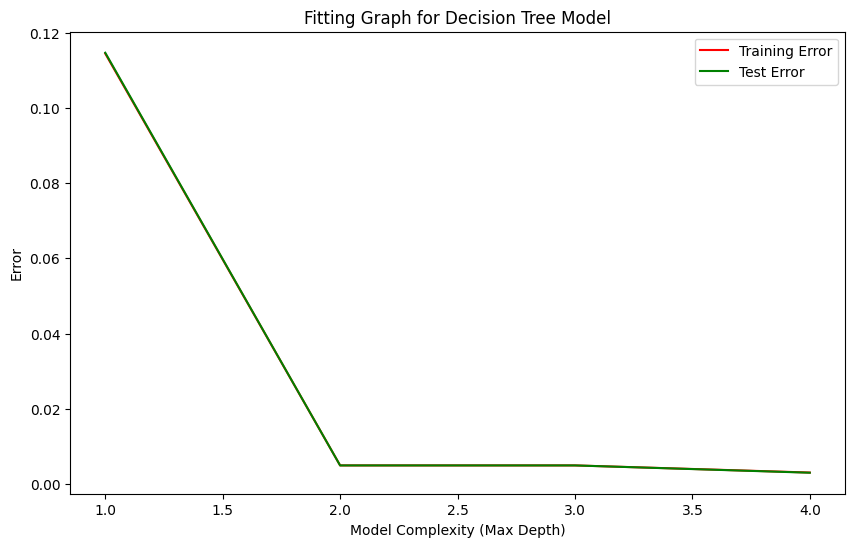

In [22]:
train_data = assembler.transform(hh_train)
test_data = assembler.transform(hh_test)

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# we can adjust the depth, but since it is a simple model we can start small first and adjust later
max_depths = range(1, 5)  

#create empty list of training and testing errors for plotting
train_errors = []
test_errors = []

# let us first define the Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

for depth in max_depths:
    # creating the Decision Tree model for current depth
    dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features", maxDepth=depth)
    
    # fitting and training model
    model = dt_classifier.fit(train_data)
    
    # calculating training error for current depth
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_error = 1 - train_accuracy
    train_errors.append(train_error)
    
    # calculating test error for current depth
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', color='red')
plt.plot(max_depths, test_errors, label='Test Error', color='green')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Error')
plt.title('Fitting Graph for Decision Tree Model')
plt.legend()
plt.show()

The training error and test error seem to be very consistent. This could be because the model is very simple and converges quickly. We will look into this more as we take our next steps.

In [15]:
df_hh.show()

+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+------------------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|YEAR|SAMPLE|SERIAL|     CBSERIAL|   HHWT|HHTYPE|      CLUSTER|CPI99|STATEICP|MET2023|STRATA| GQ|FARM|OWNERSHP|OWNERSHPD|TAXINCL|INSINCL|FOODSTMP|CINETHH|VEHICLES|COUPLETYPE|NFAMS|          ARENTGRS|ACONDOFEE|         AMOBLHOME|         AHHINCOME|           AVALUEH|         ACOSTELEC|          ACOSTGAS|         ACOSTWATR|         ACOSTFUEL|
+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+------------------+---------+------------------+------------------+------------------+------------------+------------------+----------

### New Model Predicting Ability to Own

### Without "AVALUEH"

In [16]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [17]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")
model = logistic_regression.fit(hh_norm_train)

predictions = model.transform(hh_norm_test)

# AUC-ROC
##auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7404
Precision: 0.7242
Recall: 0.7404


### With "AVALUEH"

In [18]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME", "AVALUEH"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [19]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")
model = logistic_regression.fit(hh_norm_train)

predictions = model.transform(hh_norm_test)

# AUC-ROC
##auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
